In [1]:
import sys
import os
from copy import deepcopy

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
import wandb

sys.path.append('..')

from src.configs import DataConfig, NetConfig, NetArchitecture, FilterConfig, DataType, CNNConfig, LC_SIZE, ResNetConfig
from src.utils import train, get_wandb_logger
from src.configs import PACKAGE_PATH
from src.data.data_processor import DataProcessor
from src.sweeps.sweep import DATA_CONFIG
from src.module.lightning_module import LCModule
from src.configs import AugmentType as A
from src.module.resnet import resnet20

import torch
import numpy as np
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [25]:
RUN_ID = "5jydchrf"
# import wandb

# api = wandb.Api()

# run = api.run("dano-kyselica/Rocket Bodies/5jydchrf")
# for file in run.files():
#     if "table" in repr(file):
#         file.download()
#         print(file)
import glob
path = "wandb/run-20240412_150706-5jydchrf"
files = glob.glob(f"{PACKAGE_PATH}/wandb/run-*{RUN_ID}/files/media/table/*.json")
files = sorted(files, key=lambda x: int(x.split("/")[-1].split("_")[5]))

In [43]:
import json
from collections import defaultdict
file = files[27]

d = json.load(open(file))
conf_matrix = defaultdict(lambda: defaultdict(int))
for actual, predicted, n in d['data']:
    conf_matrix[predicted][actual] = n

#print conf_matrix as markdown table
print("| | " + " | ".join([k for k in conf_matrix]) + " |")
print("|" + "---|" * (len(conf_matrix) + 1))
for k, v in conf_matrix.items():
    print("| " + k + " | " + " | ".join([str(v[k]) for k in conf_matrix]) + " |")

precision = {k: v[k]/sum(v.values()) for k, v in conf_matrix.items()}
recall = {k: v[k]/(0.000001 + sum(conf_matrix[i][k] for i in conf_matrix)) for k, v in conf_matrix.items()}
precision, recall

| | CZ-3B | Falcon 9 | Atlas 5 Centaur | H2-A | Ariane 5 | Delta 4 | Titan 3 |
|---|---|---|---|---|---|---|---|
| CZ-3B | 262.0 | 61.0 | 30.0 | 30.0 | 0.0 | 3.0 | 0.0 |
| Falcon 9 | 87.0 | 15.0 | 5.0 | 1.0 | 0.0 | 0.0 | 0.0 |
| Atlas 5 Centaur | 5774.0 | 1229.0 | 1613.0 | 1229.0 | 18.0 | 157.0 | 0.0 |
| H2-A | 0.0 | 0.0 | 2.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| Ariane 5 | 77.0 | 5.0 | 7.0 | 42.0 | 0.0 | 0.0 | 0.0 |
| Delta 4 | 1515.0 | 284.0 | 445.0 | 473.0 | 16.0 | 115.0 | 0.0 |
| Titan 3 | 204.0 | 81.0 | 54.0 | 69.0 | 0.0 | 17.0 | 0.0 |


({'CZ-3B': 0.6787564766839378,
  'Falcon 9': 0.1388888888888889,
  'Atlas 5 Centaur': 0.16097804391217566,
  'H2-A': 0.0,
  'Ariane 5': 0.0,
  'Delta 4': 0.04037921348314607,
  'Titan 3': 0.0},
 {'CZ-3B': 0.033084985473786466,
  'Falcon 9': 0.008955223875250612,
  'Atlas 5 Centaur': 0.7481447120834208,
  'H2-A': 0.0,
  'Ariane 5': 0.0,
  'Delta 4': 0.3938356150896041,
  'Titan 3': 0.0})

In [4]:
from src.configs import RB_NAMES, RB_REGEXES, SplitStrategy as ST, DatasetType as DST
from src.data.filters import filter_data


data_cfg = DataConfig(
        path=f"{PACKAGE_PATH}/Fall_2021_csv",
        output_path=f"{PACKAGE_PATH}/resources/datasets",
        # validation_path = f"{PACKAGE_PATH}/resources/SDLCD(2).csv",
        # class_names=["cz_3", "falcon_9", "atlas_V",  "h2a", "globalstar"],
        # regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R_B$',  r'H-2A.*', r'GLOBALSTAR.*'],
        class_names=RB_NAMES[:4],
        regexes=RB_REGEXES[:4],
        validation_split=0.2,
        split_strategy=ST.TRACK_ID,
        number_of_training_examples_per_class=100_000,
        filter_config=FilterConfig(n_bins=30, n_gaps= 3, gap_size=5, rms_ratio= 0., non_zero_ratio=0.8),
        # filter_config=None,
        data_types=[DataType.FS],
        wavelet_start_scale=1,
        wavelet_scales_step=1,
        wavelet_end_scale=5,
        wavelet_name= 'gaus1',
        lc_shifts = 0,
        convert_to_mag=False,
        train_augmentations=[],
)
dp = DataProcessor(data_cfg)

dp.load_data_from_file()
train_set, _, _ = dp.get_pytorch_datasets()

# data_dict, header_dict, _ = dp._read_csv_files(data_cfg.path)
# data_dict, header_dict, _ = dp._read_SDLCD_csv()
# for k, v in data_dict.items():
    # print(k, len(v))

# def simple_filter(data_dict, k):
#     res = {}
#     for key, v in data_dict.items():
#         ok = v != 0
#         x = (np.sum(ok, axis=1) / 300)  
#         res[key] = v[x >= k]
#     return res

# print("| LC measurement coverage " + " | ".join([""] + data_cfg.class_names) + " |")
# print("| --- " + " | ".join([""] + ["---"]*len(data_cfg.class_names)) + " |")
# for k in [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
#     data_cfg.filter_config.non_zero_ratio = k
# #     fileted, _ = filter_data(data_dict, header_dict, data_cfg.filter_config)
#     fileted = simple_filter(data_dict, k)
#     print("| "+ " | ".join([str(int(k*100))+"%"] + [f"{len(fileted[c])}" for c in data_cfg.class_names]) + " |")



Hash: 003eb37a0386c4dbf82b01cc11742535


Splitting H2-A: 100%|██████████| 352/352 [00:00<00:00, 13267.51it/s]

False False


(7919, 16)


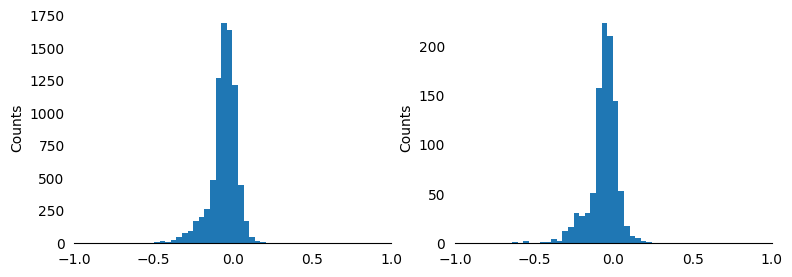

In [63]:
X,y = train_set.data, train_set.labels
ok = y == 0
X2 = X[ok]
y2 = y[ok]

fs1 = X2[:,0]
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(4,1, figsize=(10,10))
# for i in range(4):
#     hist = np.histogram(X[y==i][:,13], bins=30)
#     print(i, hist[0])
#     ax[i].bar(hist[1][:-1], hist[0], width=hist[1][1]-hist[1][0])
#     ax[i].set_title(f"Class {data_cfg.class_names[i]}")
#     ax[i].set_xlim(-1,1)

print(X2.shape)
hist, edges = np.histogramdd(X2[:,list(range(5))], bins=[30]*5)
NBINS = 30
VALS = 1000
IDX = 0
def random_coef(data, nbins, num, coef_idx):
    hist, edges = np.histogram(data[:,coef_idx], bins=nbins)
    mid_points = (edges[:-1] + edges[1:]) / 2

    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = mid_points[value_bins]


    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 3))
    ax0.hist(data[:,coef_idx], bins=edges)
    ax1.hist(random_from_cdf, bins=edges)
    return ax0,ax1

ax0, ax1 = random_coef(X2, NBINS, VALS, IDX)

for ax in (ax0, ax1):
    ax.set(xlim=(-1,1), ylabel='Counts')
    ax.tick_params(axis='x', color='none')
    ax.tick_params(axis='y', color='none')
    [ax.spines[d].set_visible(False) for d in ('top', 'left', 'right')]

# a1 = np.random.choice(hist[1],p=np.array(hist[0])/sum(hist[0]))


In [2]:
data_cfg: DataConfig = deepcopy(DATA_CONFIG)
data_cfg.validation_path = f"{PACKAGE_PATH}/resources/SDLCD.csv"
data_cfg.data_types = [DataType.LC]
data_cfg.wavelet_scales = 10
data_cfg.train_augmentations = []
# data_cfg.train_augmentations = [A.SHIFT]
# data_cfg.train_augmentations = [A.MIX_UP]
# data_cfg.train_augmentations = [A.SHIFT, A.MIX_UP]

net_cfg = NetConfig(
    name="Resnet20", input_size=LC_SIZE, 
    class_names=data_cfg.class_names,
    output_size=len(data_cfg.class_names),
    architecture=NetArchitecture.RESNET,
    learning_rate=0.001,
    label_smoothing=0.,
    use_mixup=False,
    args=ResNetConfig(n_layers=20, in_channels=10)
    # args=CNNConfig(input_size=LC_SIZE, output_size=5, in_channels=1, 
    #             conv_layers=[(16,7, 5),(32, 3, 1)], 
    #             classifier_layers=[])
)

In [3]:
dp = DataProcessor(data_cfg)

if os.path.exists(f'{dp.output_path}/{dp.hash}'):
    dp.load_data_from_file()
    dp.load_data_from_file(test=True)
else:
    dp.create_dataset_from_csv()
    dp.save_data(test=True)
    dp.save_data()

train_set, val_set, test_set = dp.get_pytorch_datasets()


False False


In [4]:

(X_train, y_train), (X_val, y_val), (X_test, y_test) = dp.prepare_dataset()
X_train.shape

(17554, 300)

In [5]:
from src.utils import get_wandb_logger

# logger = get_wandb_logger("Renet_LC", "Baseline")
logger = None

In [6]:
module = LCModule(net_cfg)

In [7]:
train(module=module,
      dp=dp,
      num_epochs=2,
      batch_size=32,
      num_workers=4,
      callbacks=[],
      # callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')],
      sampler=False,
      max_num_samples=10_000,
      logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


False False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | ResNet           | 94.0 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
94.0 K    Trainable params
0         Non-trainable params
94.0 K    Total params
0.376     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 548/548 [00:12<00:00, 43.06it/s, v_num=1, train_loss=1.180, train_acc=0.531, val_loss=1.400, val_acc=0.484]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 548/548 [00:12<00:00, 42.98it/s, v_num=1, train_loss=1.180, train_acc=0.531, val_loss=1.400, val_acc=0.484]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 153.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6458333134651184
        test_loss           0.9067791104316711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [2]:
a = '''| CZ-3               | 1512 | 190      | 105     | 8    | 2          |
| Falcon 9           | 439  | 240      | 71      | 16   | 2          |
| Atlas V            | 58   | 10       | 304     | 29   | 1          |
| H2-A               | 7    | 2        | 21      | 418  | 2          |
| Globalstar         | 18   | 0        | 51      | 12   | 866        |'''

import numpy as np

s = np.array([[1512, 190, 105, 8, 2], [439, 240, 71, 16, 2], [58, 10, 304, 29, 1], [7, 2, 21, 418, 2], [18, 0, 51, 12, 866]])
precision = np.diag(s) / np.sum(s, axis=0)
recall = np.diag(s) / np.sum(s, axis=1)
f1 = 2 * precision * recall / (precision + recall)

print(precision)
print(recall)
print(f1)

[0.74336283 0.54298643 0.55072464 0.86542443 0.99198167]
[0.83214089 0.3125     0.75621891 0.92888889 0.91446674]
[0.78525058 0.39669421 0.63731656 0.8960343  0.95164835]


In [3]:
(0.82 + 0.3 + 0.47 +0.93  + 0.98) / 5

0.7

In [5]:
# | 0.89  | 0.133    | 0.438   | 0.886 |
# compute average
(0.89 + 0.133 + 0.438 + 0.886) / 4

0.708

In [20]:
'''
| predicted / actual | CZ-3 | Falcon 9 | Atlas V | H2-A | Globalstar |
| ------------------ | ---- | -------- | ------- | ---- | ---------- |
| CZ-3               | 1512 | 190      | 105     | 8    | 2          |
| Falcon 9           | 439  | 240      | 71      | 16   | 2          |
| Atlas V            | 58   | 10       | 304     | 29   | 1          |
| H2-A               | 7    | 2        | 21      | 418  | 2          |
| Globalstar         | 18   | 0        | 51      | 12   | 866        |
'''
a = np.array([[1512, 190, 105, 8, 2], [439, 240, 71, 16, 2], [58, 10, 304, 29, 1], [7, 2, 21, 418, 2], [18, 0, 51, 12, 866]])
precision = np.diag(a) / np.sum(a, axis=1)
recall = np.diag(a) / np.sum(a, axis=0)
f1 = 2 * precision * recall / (precision + recall)
print(precision)
print(recall)
print(f1)

# print formated as markdown table 
print("| | CZ-3 | falcon 9 | atlas V | H2-A | Globalstar | Avg. |")
print("|---|------|----------|---------|------|------------|------|")
for metric, name in zip([precision, recall, f1], ["precision", "recall", "f1"]):
    print(f"| {name} | {' | '.join([f'{m:.2f}' for m in metric])} | {np.mean(metric):.2f} |")
    
# average of each metric
print(np.mean(precision))
print(np.mean(recall))
print(np.mean(f1))


[0.83214089 0.3125     0.75621891 0.92888889 0.91446674]
[0.74336283 0.54298643 0.55072464 0.86542443 0.99198167]
[0.78525058 0.39669421 0.63731656 0.8960343  0.95164835]
| | CZ-3 | falcon 9 | atlas V | H2-A | Globalstar | Avg. |
|---|------|----------|---------|------|------------|------|
| precision | 0.83 | 0.31 | 0.76 | 0.93 | 0.91 | 0.75 |
| recall | 0.74 | 0.54 | 0.55 | 0.87 | 0.99 | 0.74 |
| f1 | 0.79 | 0.40 | 0.64 | 0.90 | 0.95 | 0.73 |
0.7488430846010933
0.7388959995829597
0.7333888021193269


# Synthetic multiarray to .csv

In [2]:
import os
import sys
import glob 
import pandas as pd
import numpy as np

sys.path.append('..')
sys.path.append('.')

from src.data.load_multi_array import load_multi_array
from src.configs import PACKAGE_PATH

In [12]:
path = "~/work/artificial_data/data/all"

In [32]:
files = glob.glob(os.path.expanduser(path) + "/../*/*.npy")
files

['/home/k/kyselica12/work/artificial_data/data/all/../all/AtlasV_All_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../all/GlobalStar_all_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../all/H2A_All_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../all/CZ3_all_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../all/Falcon9_all_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../TEST3/TEST3_PHS_90_OBS_90_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../TEST3/TEST3_PHS_0_OBS_0_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../TEST3/TEST3_PHS_90_OBS_0_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../TEST3/TEST3_PHS_0_OBS_90_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../all_one_color/CZ_3_all_white_multi_array.npy',
 '/home/k/kyselica12/work/artificial_data/data/all/../all_one_color/ATLAS_V_a

In [18]:
import numpy as np


for f in files:
    data = load_multi_array(f)
    offset = 0
    name = "TEST"

    if "Atlas" in f:
        name = "Atlas_V"
        offset = 1
    elif "CZ3" in f:
        name = "CZ-3B_R_B"
        offset = 2001 
    elif "Falcon" in f:
        name = "FALCON_9"
        offset = 4001
    elif "H2A" in f:
        name = "H-2A_R_B"
        offset = 6001
    elif "GlobalStar" in f:
        name = "GLOBALSTAR"
        offset = 8001
    else:
        raise ValueError(f"Unknown file {f}")
    
    for i in range(data.shape[0]):
        arr = data[i]
        arr[arr != 0] = -2.5 * np.log10(arr[arr != 0])

    header = np.ones((data.shape[0],3))
    header[:, 0] = offset
    header[:, 1] = np.arange(data.shape[0]) + offset
    labels = ["Object ID","Track ID","Phase"] + [f"{i}" for i in range(data.shape[1])]
    all_data = np.concatenate([header, data], axis=1)
    df = pd.DataFrame(all_data, columns=labels)
    df.to_csv(f"{PACKAGE_PATH}/artificial_data/{name}.csv", index=False)



(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)

In [25]:
mmax = np.max(data, axis=1,keepdims=True)
mmin = np.min(data, axis=1,keepdims=True)

noise = np.random.randn(*data.shape) * (mmax - mmin) * 0.1
noise.shape

(1800, 1)


(1800, 300)

In [14]:
import sys
sys.path.append("../")
from src.data.data_processor import DataProcessor
from src.configs import DataType as DT, SplitStrategy as ST, AugmentType as A, DataConfig, FilterConfig, PACKAGE_PATH, DataType


data_cfg = DataConfig(
        path=f"{PACKAGE_PATH}/Fall_2021_csv",
        output_path=f"{PACKAGE_PATH}/resources/datasets",
        # artificial_data_path=f"{PACKAGE_PATH}/artificial_data",
        # validation_path = f"{PACKAGE_PATH}/resources/SDLCD.csv",
        class_names=["cz_3", "falcon_9", "atlas_V",  "h2a", "ariane5", "delta4", "titan3"],
        regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R.B$',  
                 r'H-2A.*', r'ARIANE_5.*', r'DELTA_4.*', r'TITAN_3C_TRANSTAGE.*'],
        # class_names=["cz_3", "falcon_9", "atlas_V",  "h2a"],
        # regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R_B$',  r'H-2A.*'],
        validation_split=0.2,
        split_strategy=ST.TRACK_ID,
        number_of_training_examples_per_class=10_000,
        filter_config=FilterConfig( n_bins= 30, n_gaps= 10, gap_size= 5, rms_ratio= 0., non_zero_ratio=0.8),
        data_types=[DataType.WAVELET],
        wavelet_start_scale=1,
        wavelet_scales_step=1,
        wavelet_end_scale=5,
        wavelet_name= 'gaus1',
        lc_shifts = 0,
        convert_to_mag=False,
        train_augmentations=[A.SHIFT],
)

In [15]:
dp = DataProcessor(data_cfg)

In [16]:
dp.test_path = f"{PACKAGE_PATH}/resources/SDLCD(2).csv"
x = dp._read_SDLCD_csv()

Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...
Object ATLAS_CENTAUR_R/B not recognized. Skipping...


In [17]:
[(i,len(x[0][i])) for i in x[0]]

[('cz_3', 154),
 ('falcon_9', 126),
 ('atlas_V', 63),
 ('h2a', 33),
 ('ariane5', 218),
 ('delta4', 68),
 ('titan3', 57)]

# Visualizations

In [3]:
from src.configs import SplitStrategy as ST, DatasetType as DST, AugmentType as A
data_cfg = DataConfig(
        path=f"{PACKAGE_PATH}/Fall_2021_csv",
        output_path=f"{PACKAGE_PATH}/resources/datasets",
        # validation_path = f"{PACKAGE_PATH}/resources/SDLCD(2).csv",
        # artificial_data_path=f"{PACKAGE_PATH}/artificial_hist",
        class_names=["cz_3", "falcon_9", "atlas_V",  "h2a", "globalstar"],
        regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R_B$',  r'H-2A.*', r'GLOBALSTAR.*'],
        # class_names=RB_NAMES[:4],
        # regexes=RB_REGEXES[:4],
        validation_split=0.2,
        split_strategy=ST.TRACK_ID,
        number_of_training_examples_per_class=100_000,
        filter_config=FilterConfig(n_bins=30, n_gaps= 10, gap_size=5, rms_ratio= 0., non_zero_ratio=0.8),
        # filter_config=None,
        data_types=[DataType.WAVELET],
        wavelet_start_scale=1,
        wavelet_scales_step=1,
        wavelet_end_scale=5,
        wavelet_name= 'gaus1',
        lc_shifts = 0,
        convert_to_mag=False,
        train_augmentations=[A.SHIFT],
)


net_cfg = NetConfig(
    name="Resnet20", input_size=LC_SIZE, 
    class_names=data_cfg.class_names,
    output_size=len(data_cfg.class_names),
    architecture=NetArchitecture.RESNET,
    args=ResNetConfig(n_layers=20, in_channels=5, output_size=5),
    learning_rate=0.001,
    label_smoothing=0.1,
)

from copy import deepcopy
data_cfg2 = deepcopy(data_cfg)
data_cfg2.data_types = [DataType.LC]
dp = DataProcessor(data_cfg)
dp2 = DataProcessor(data_cfg2)
print("LOAD")

dp.load_data_from_file(DST.TRAIN)
dp2.load_data_from_file(DST.TRAIN)


Hash: bbc2edd469837ac2ea571e3cd2ad75cc
Hash: bbc2edd469837ac2ea571e3cd2ad75cc
LOAD


In [4]:
train_set, val_set, test_set = dp.get_pytorch_datasets()
train_set2, val_set2, _ = dp2.get_pytorch_datasets()
module_path = "/home/k/kyselica12/work/classification_of_light_curves/resources/models/4 Rocket Bodies/Wavelet best/epoch=28-step=9048.ckpt"
module = LCModule.load_from_checkpoint(module_path)
module.eval()

Splitting globalstar: 100%|██████████| 1821/1821 [00:32<00:00, 56.34it/s] 


False True


Splitting globalstar: 100%|██████████| 1821/1821 [00:06<00:00, 283.63it/s] 


False True


LCModule(
  (net): ResNet(
    (conv1): Conv1d(5, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
        (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(16, 16, kernel_si

In [5]:
from torch.utils.data import DataLoader

val_loader = DataLoader(val_set, 
                            batch_size=1,
                            num_workers=0,
                            shuffle=False,
                            drop_last=False)
val_loader2 = DataLoader(val_set2, 
                            batch_size=1,
                            num_workers=0,
                            shuffle=False,
                            drop_last=False)

FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 0
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 1
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 2
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 3
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4
FOUND 4


/tmp/ipykernel_1869946/395625281.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1)


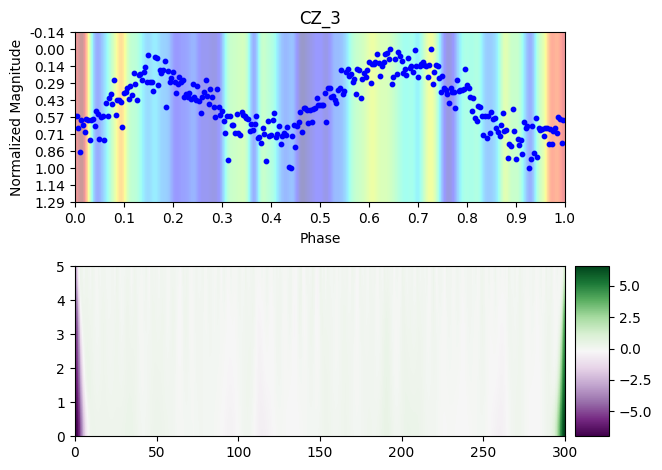

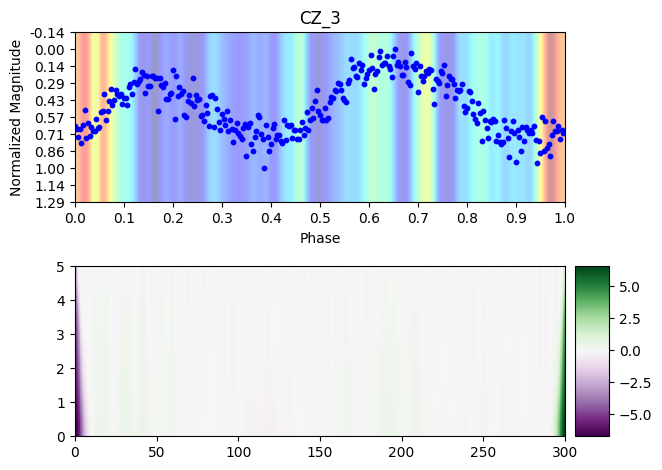

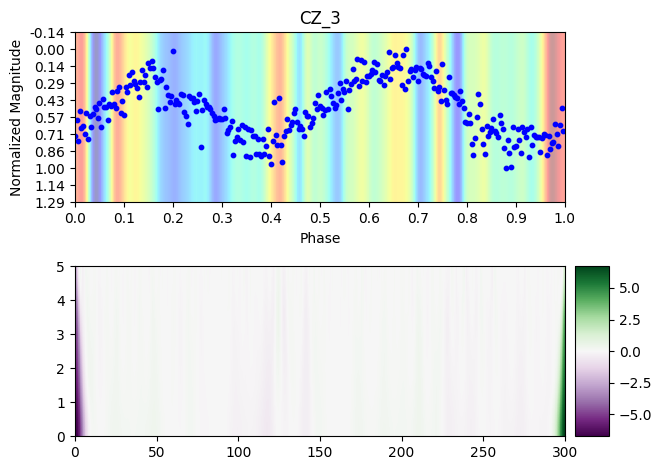

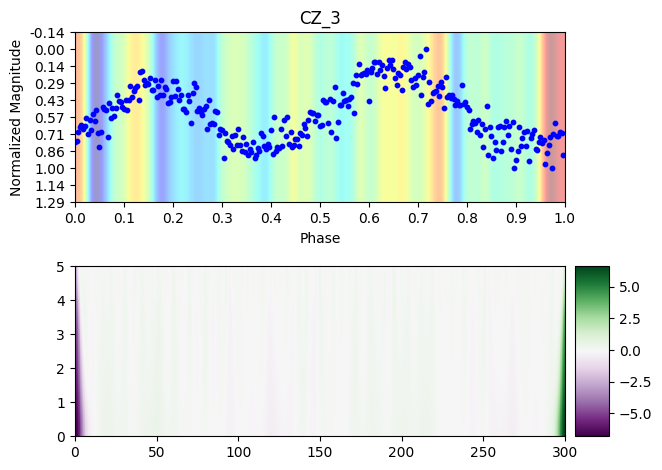

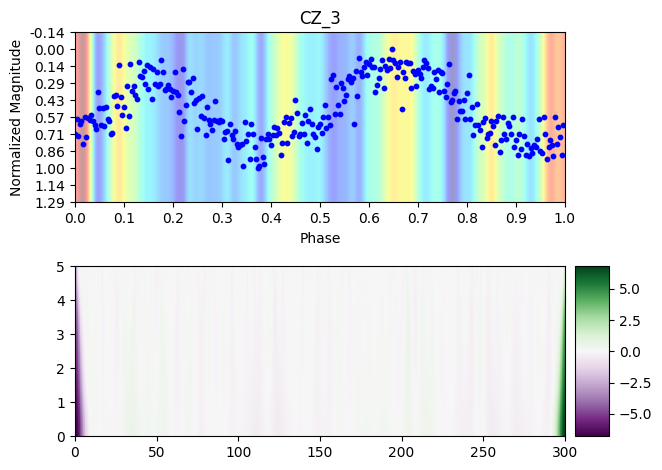

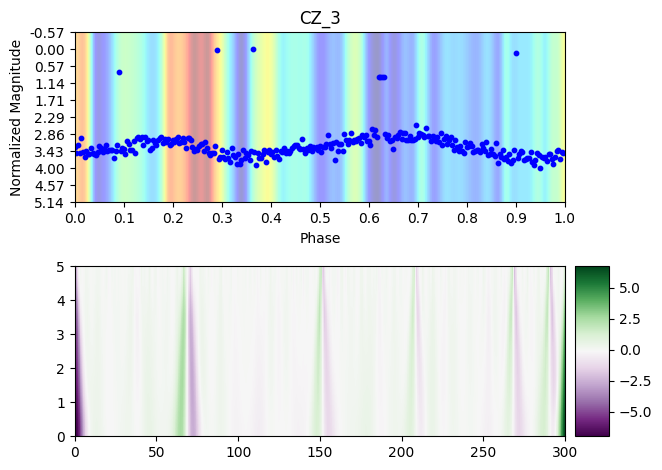

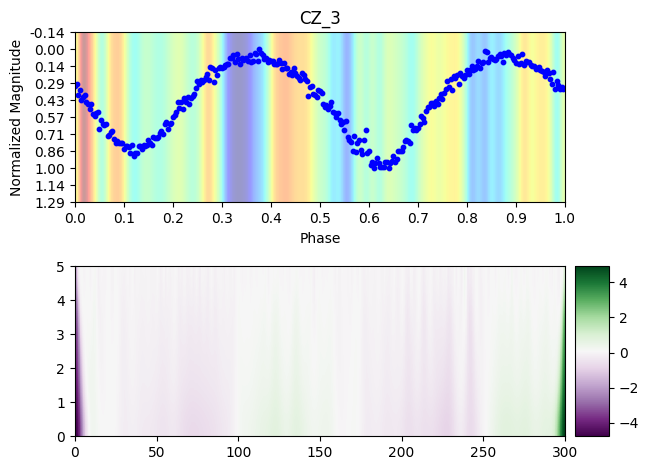

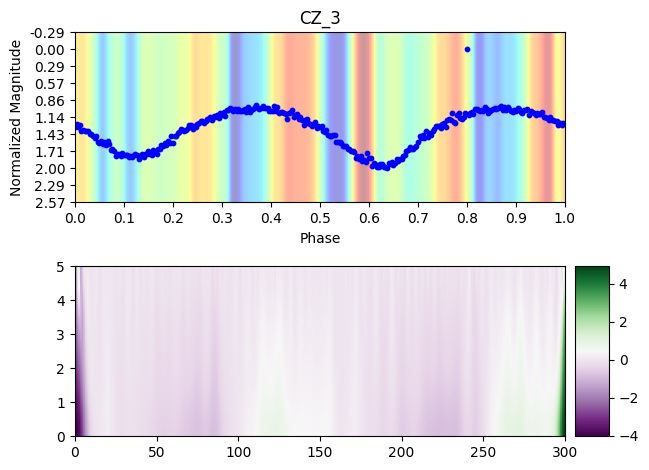

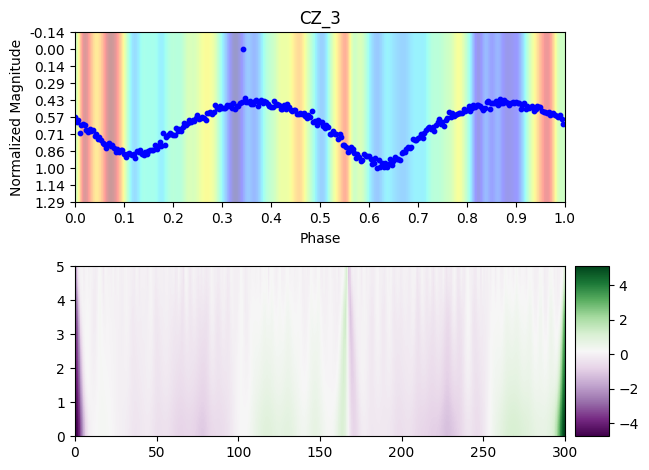

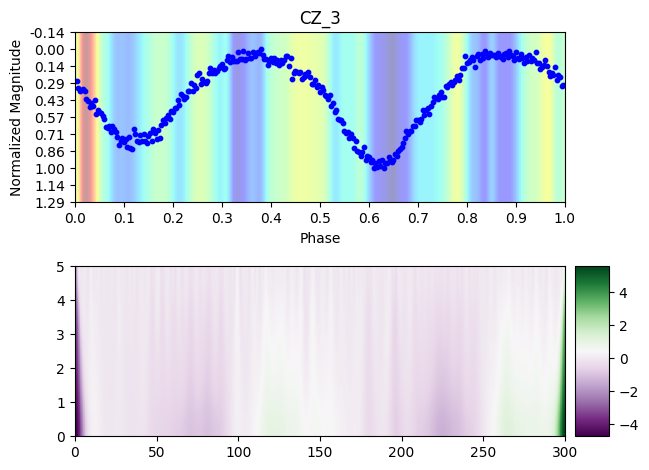

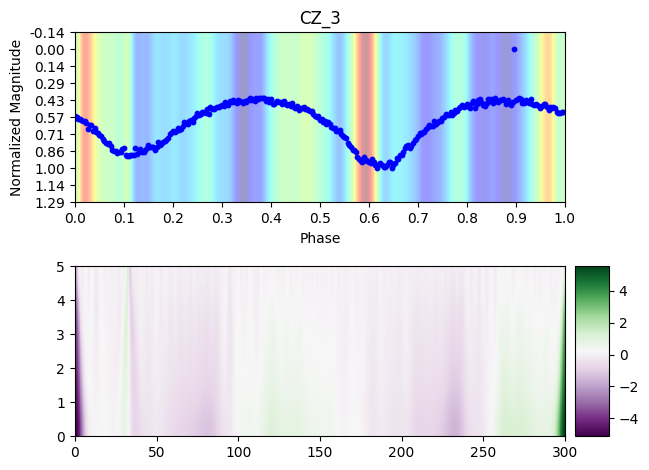

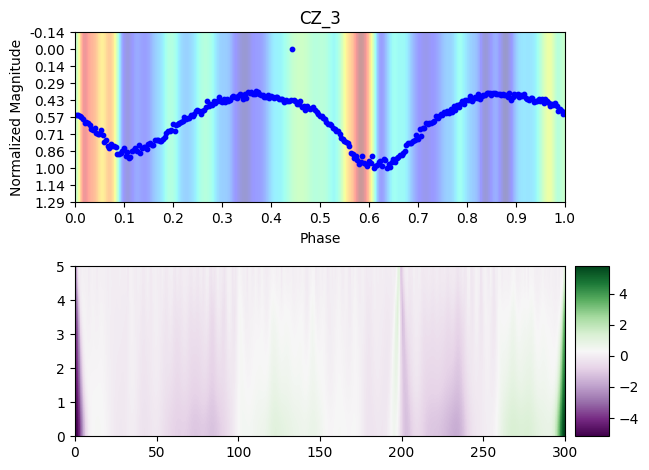

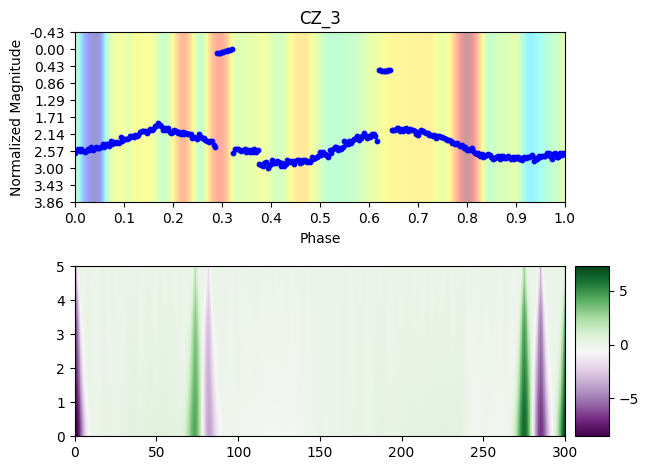

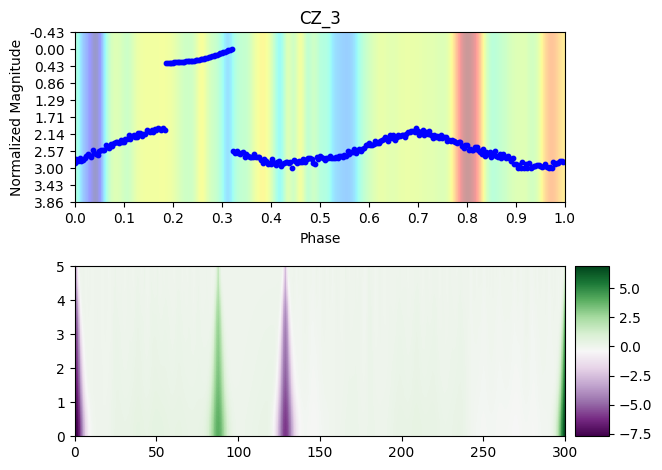

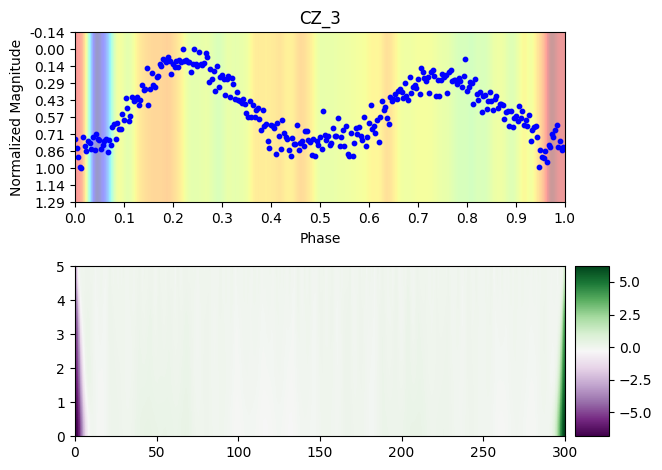

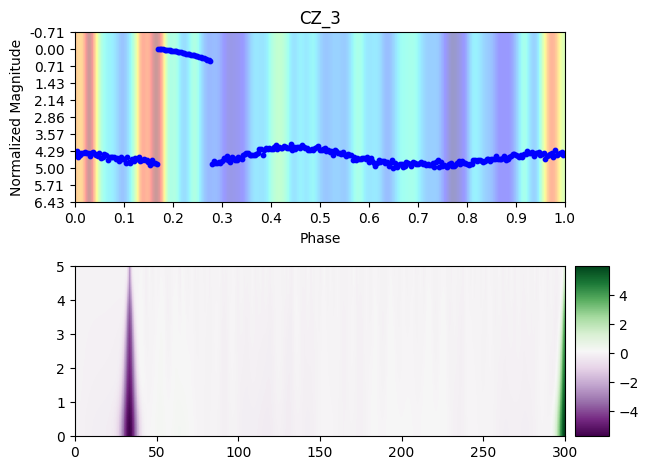

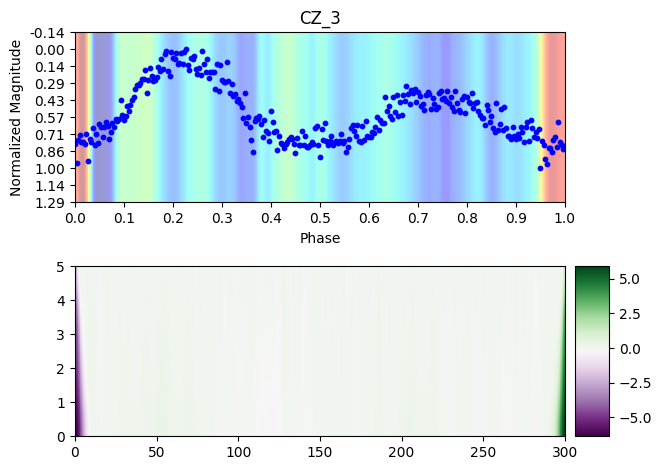

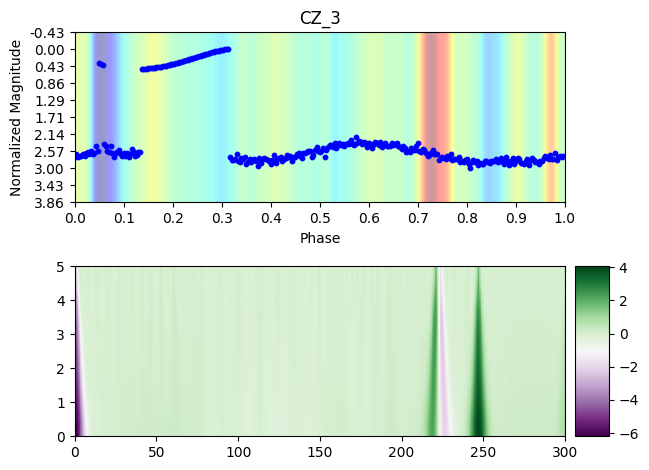

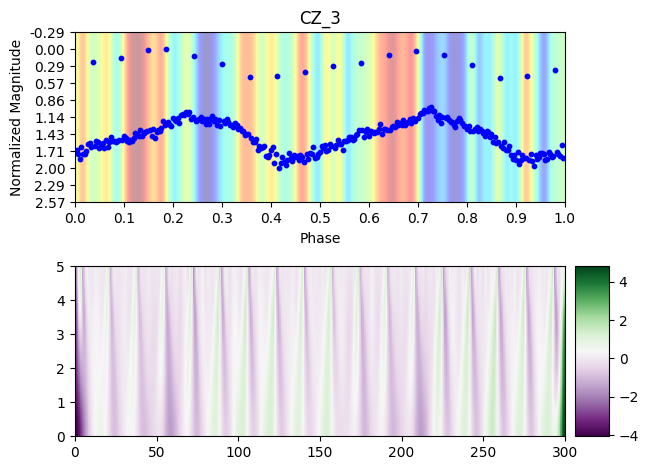

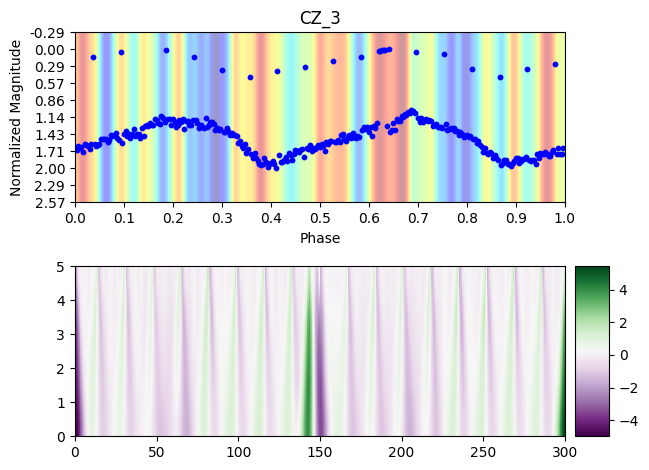

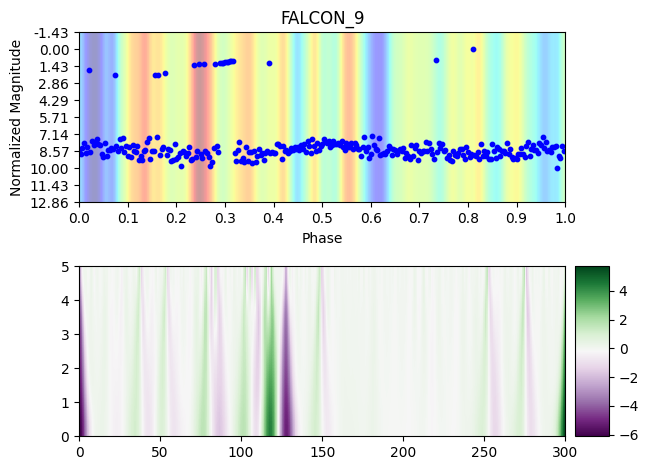

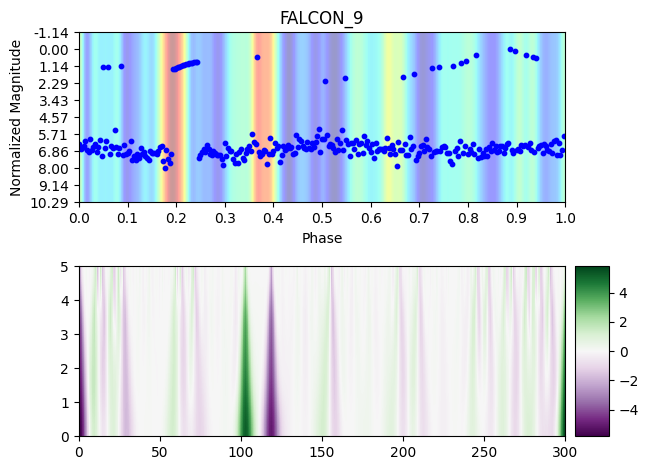

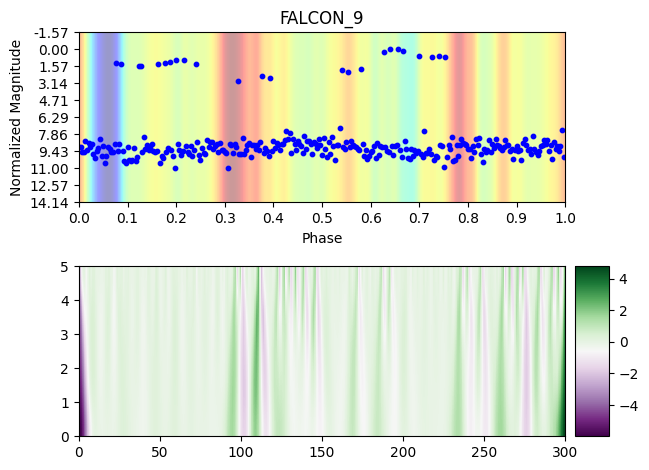

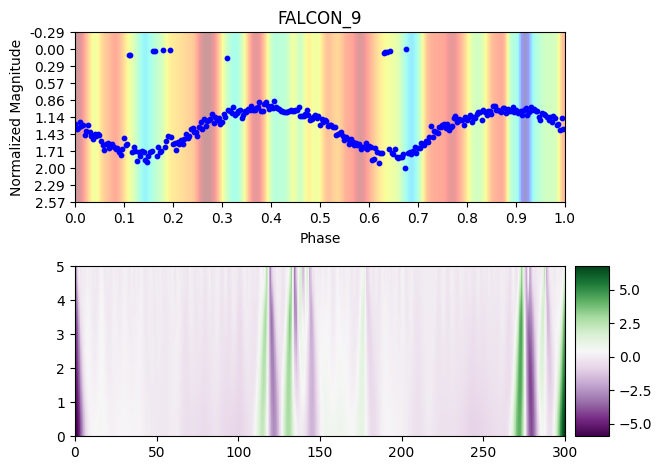

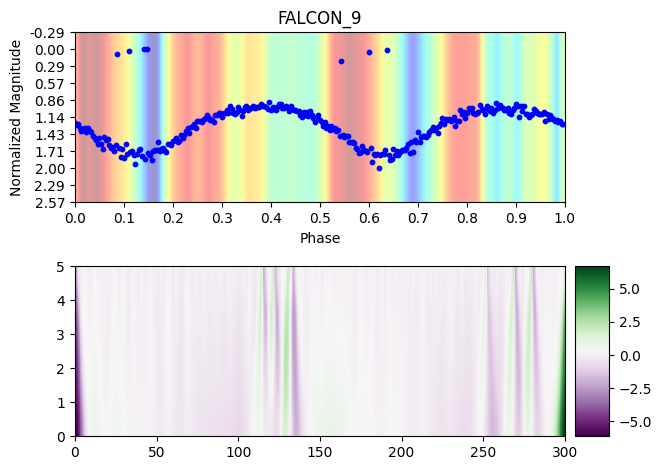

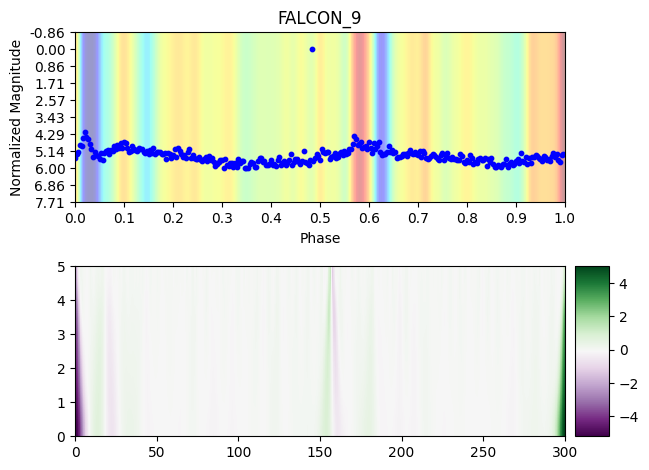

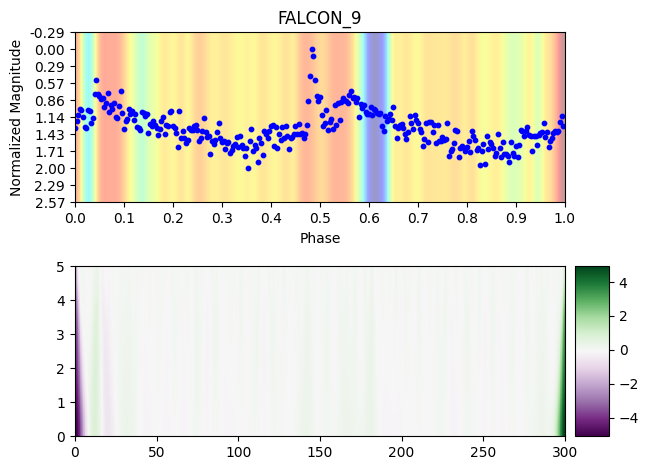

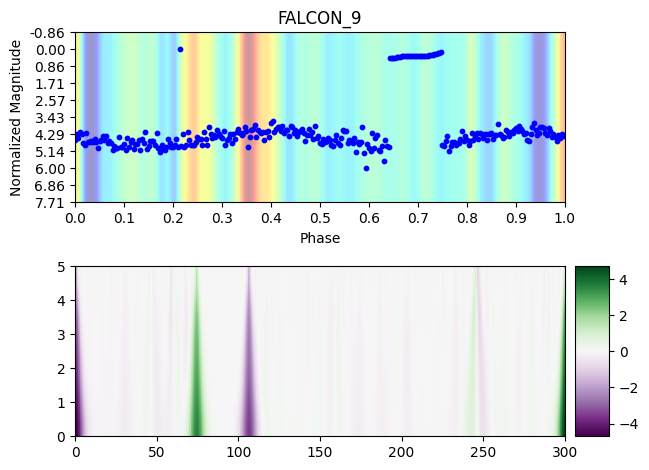

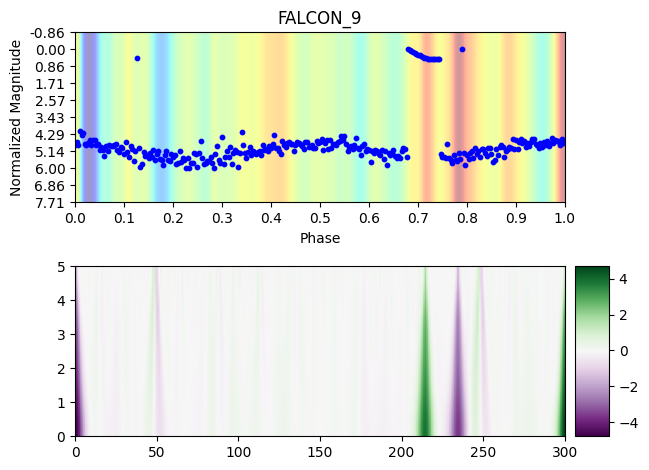

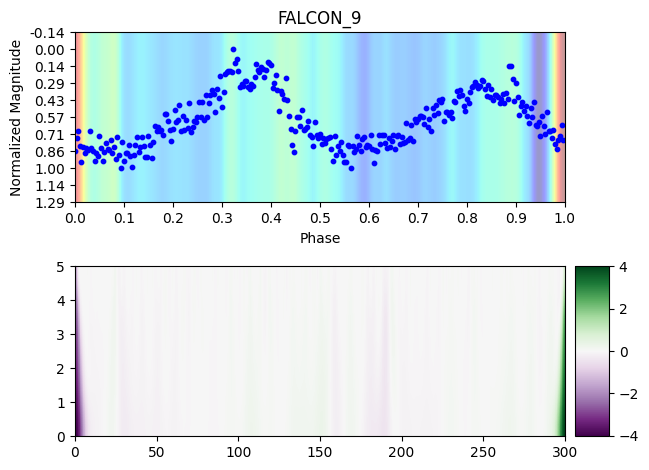

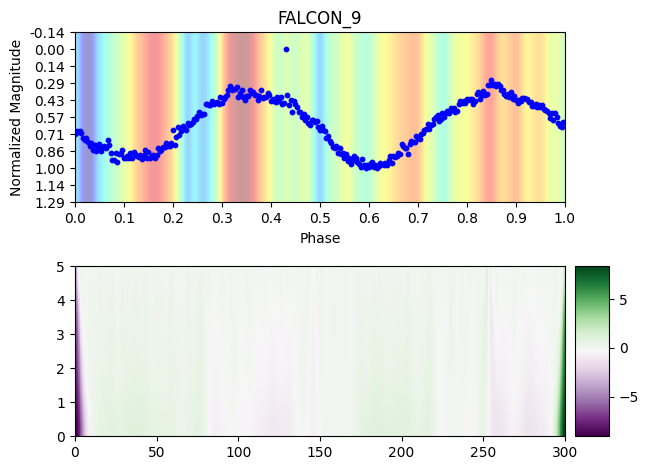

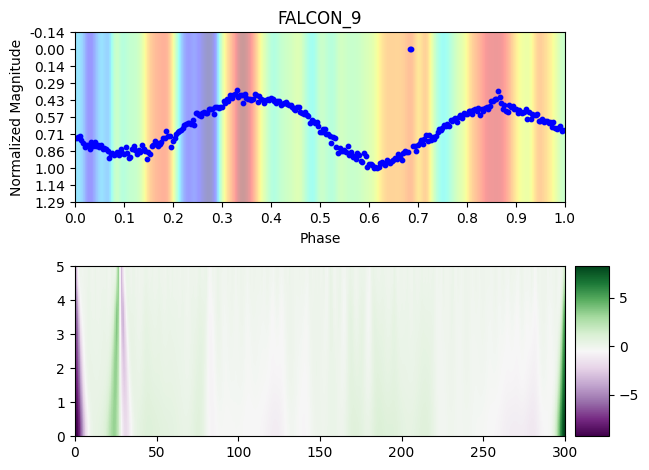

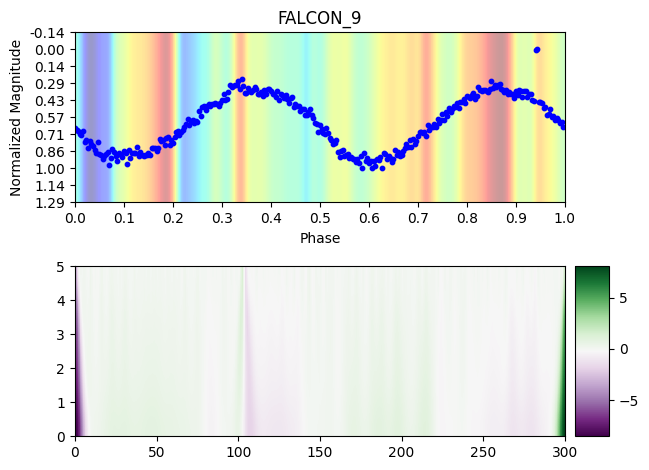

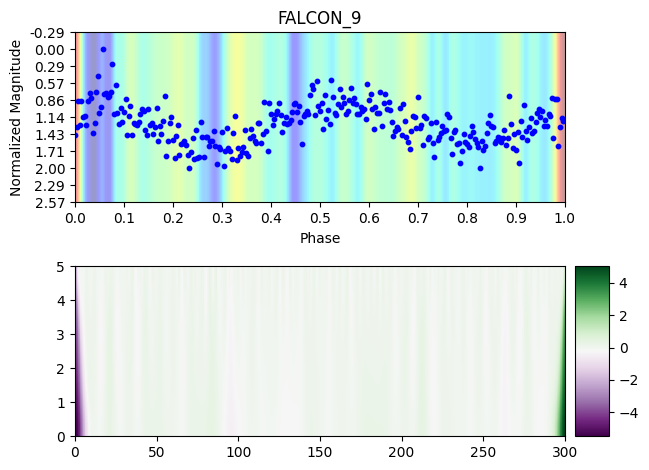

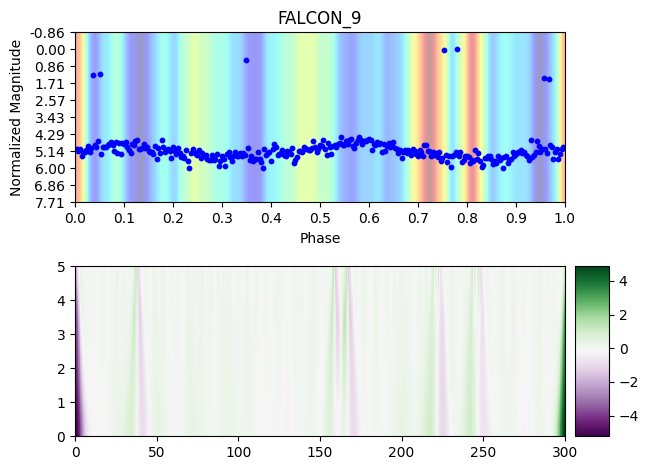

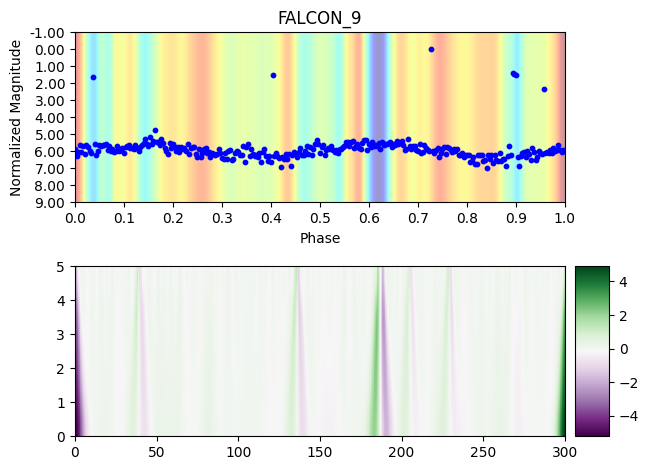

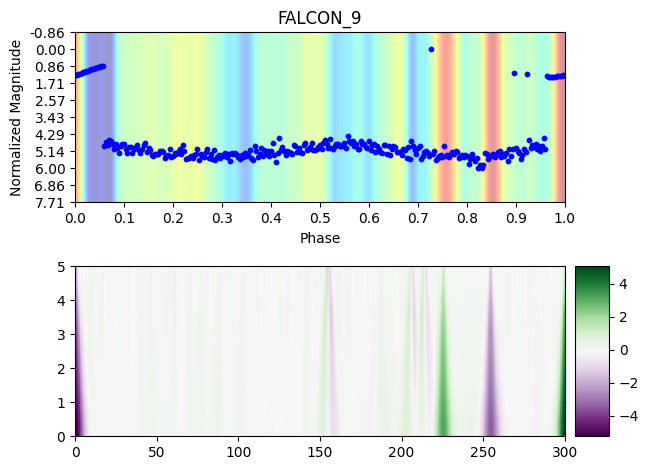

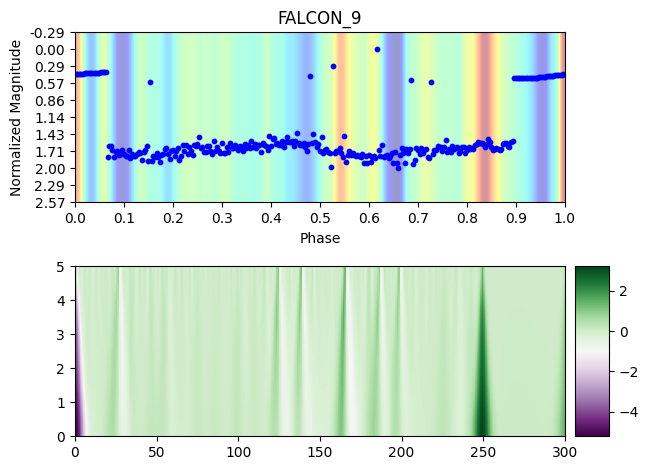

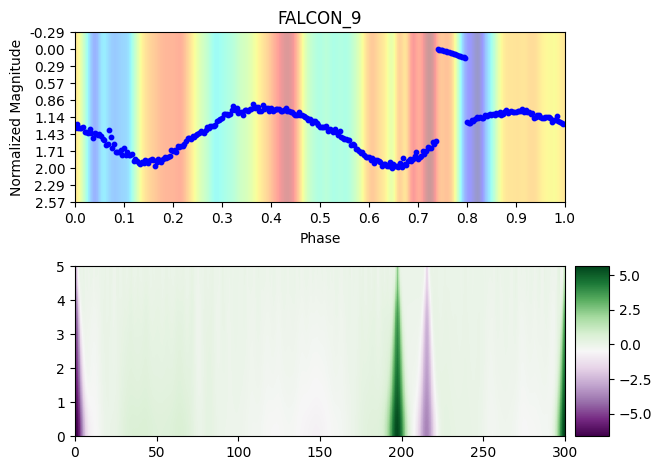

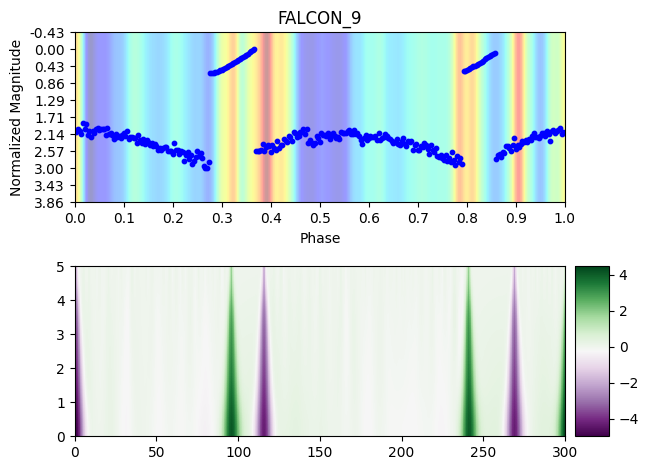

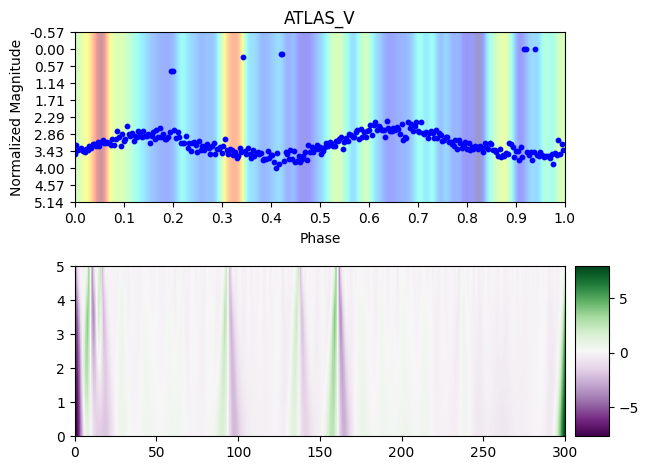

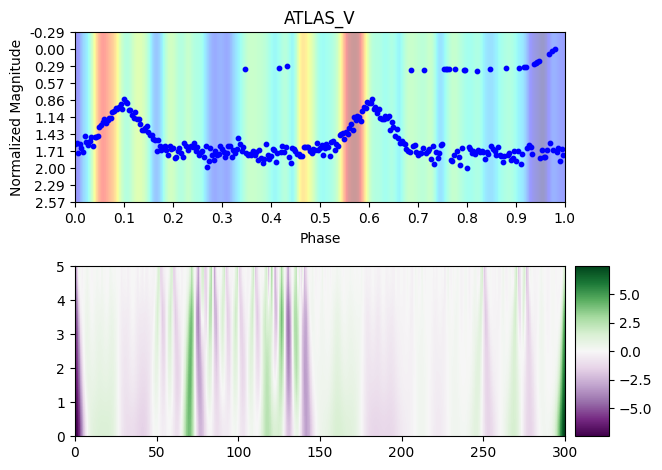

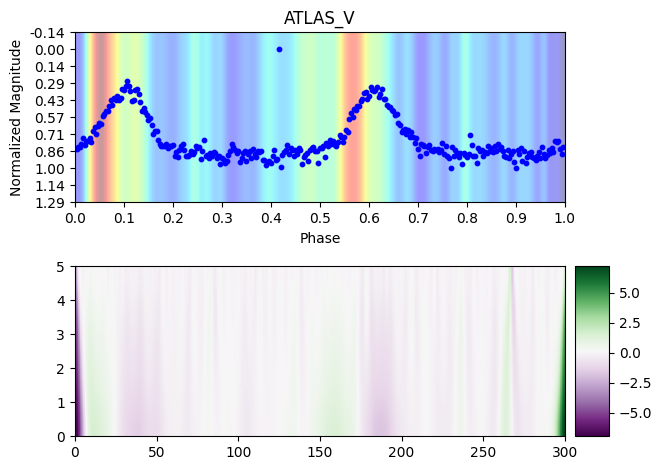

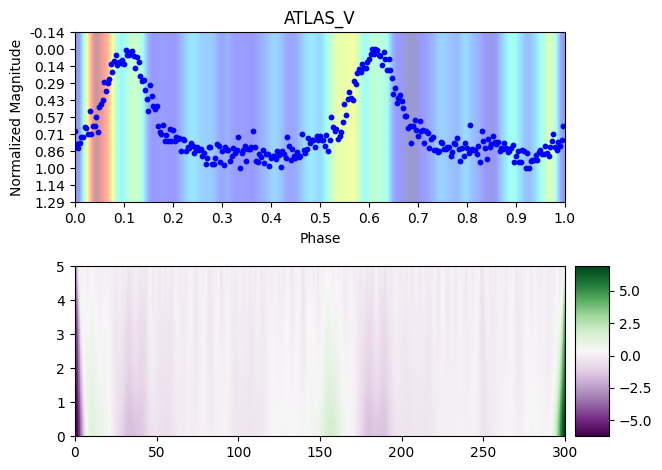

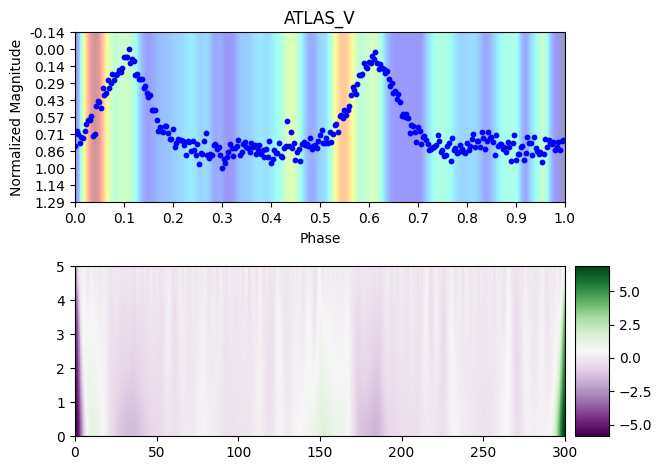

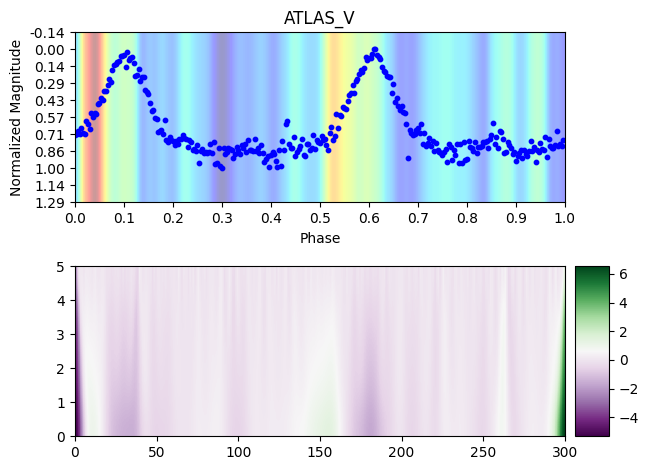

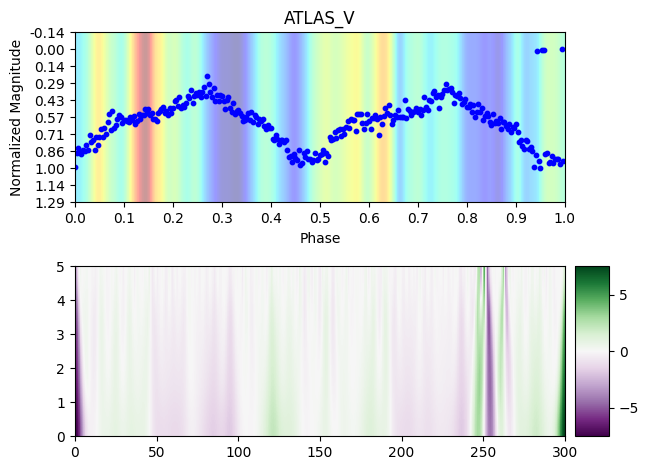

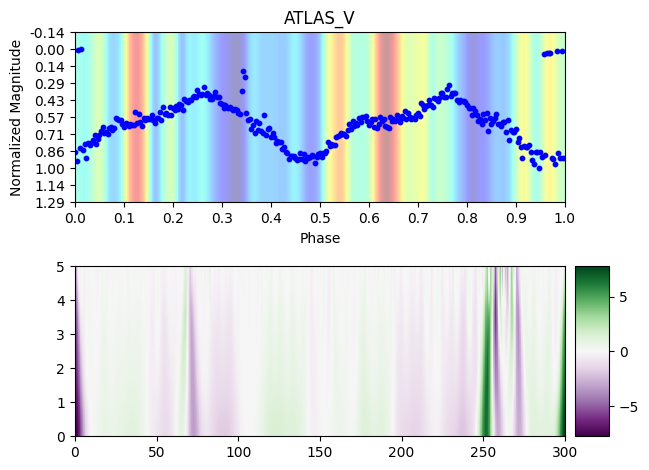

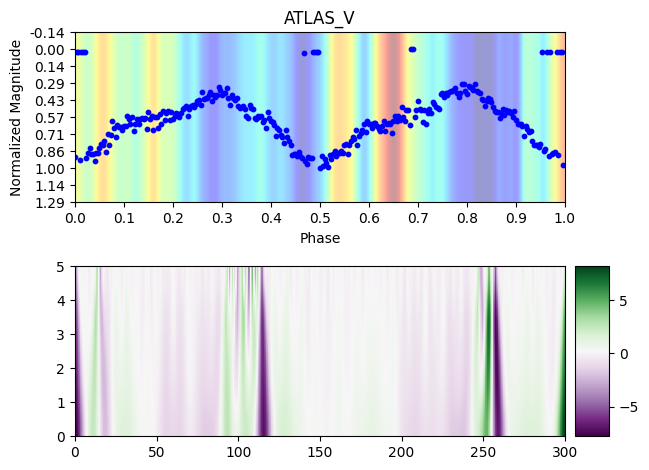

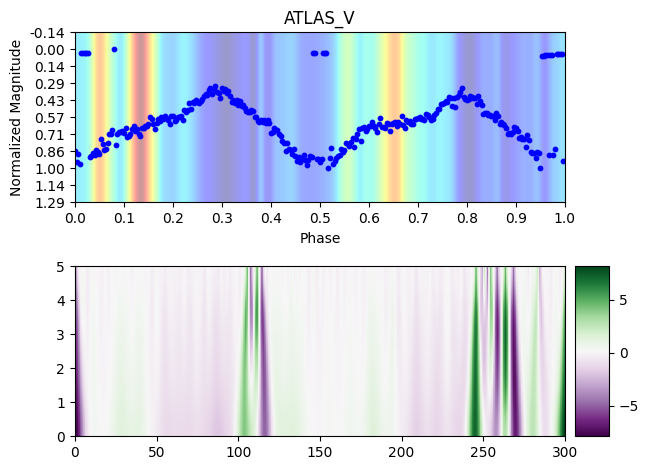

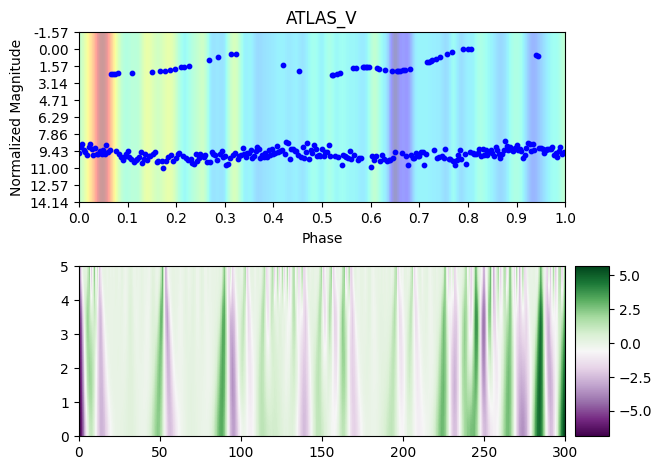

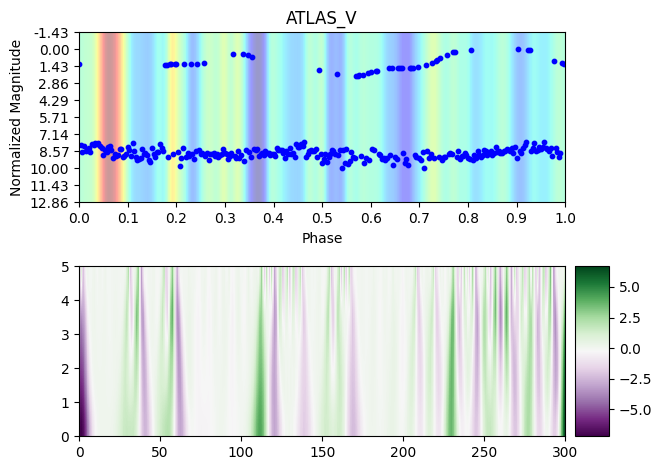

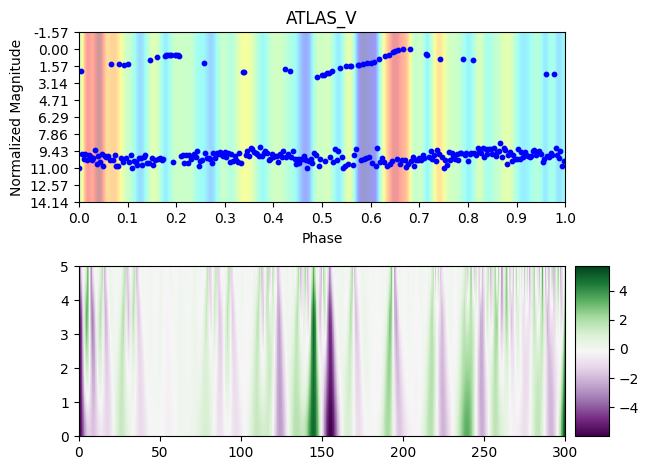

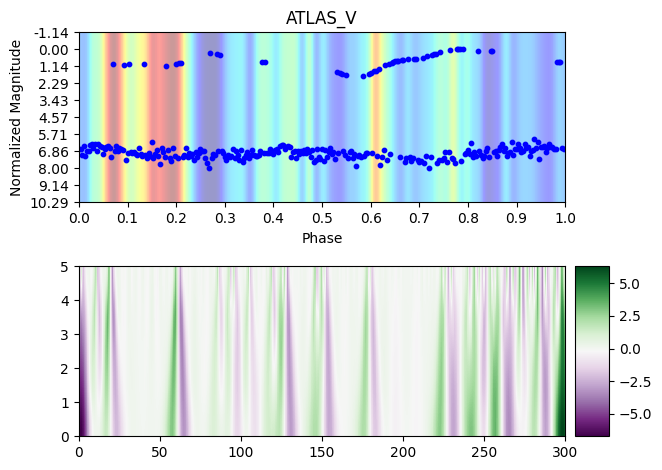

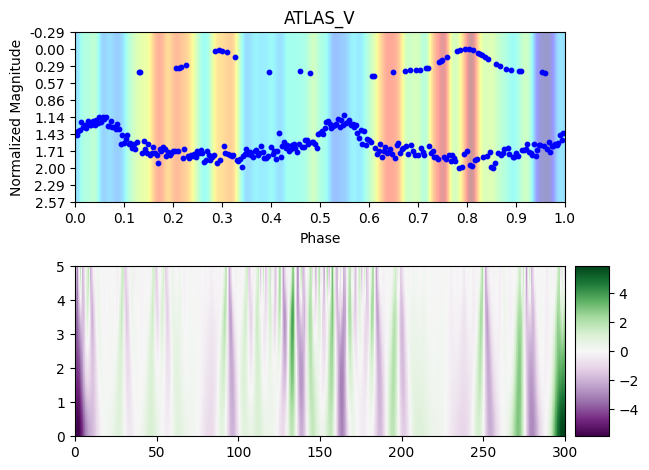

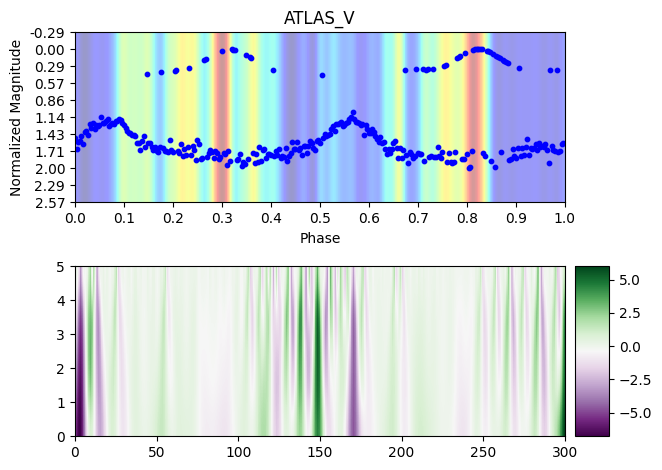

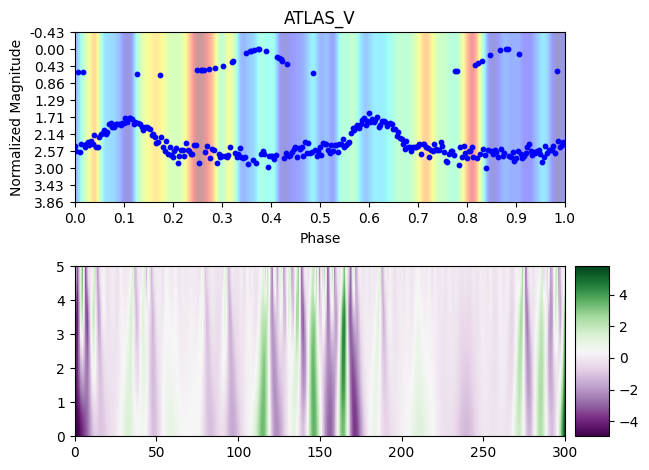

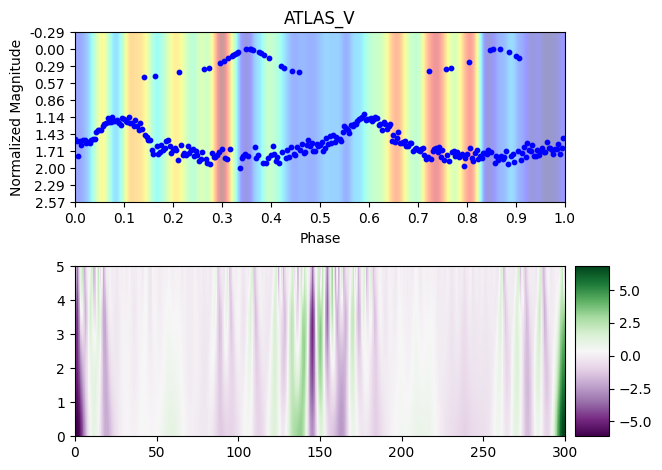

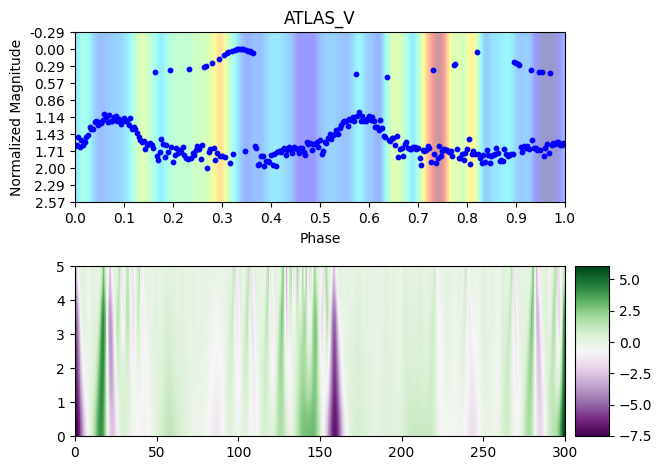

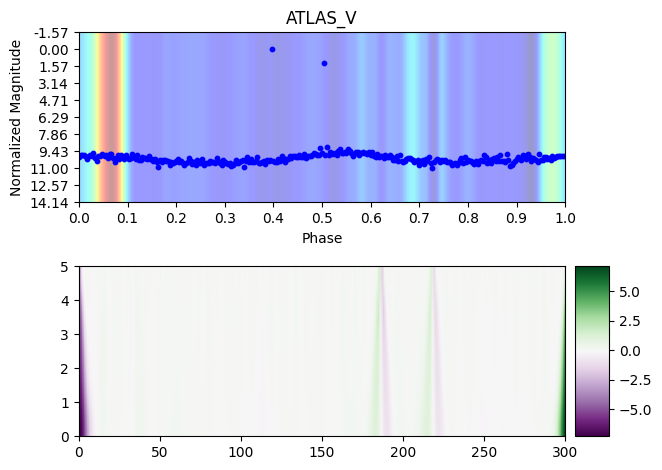

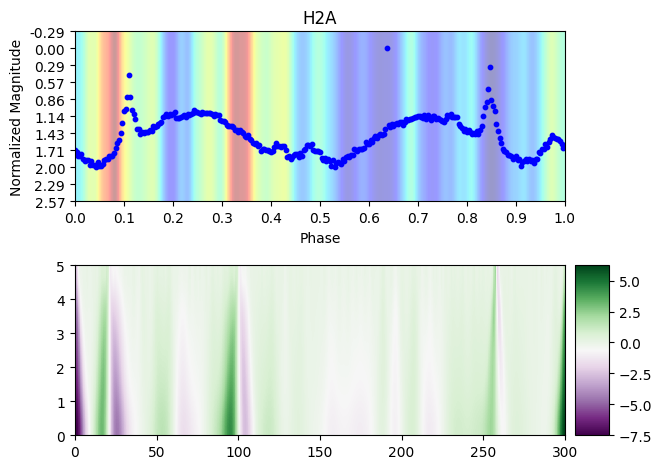

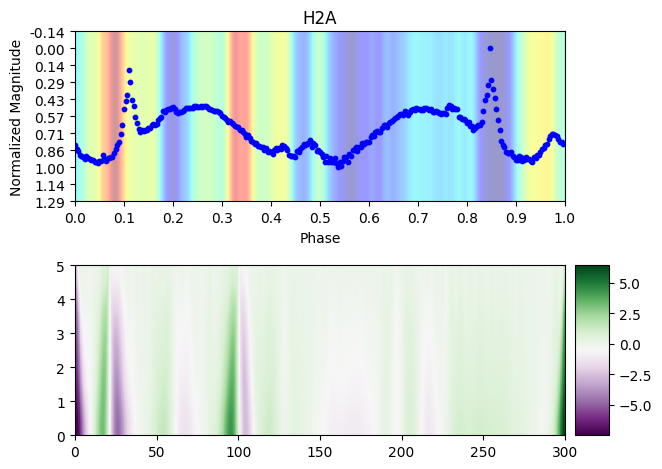

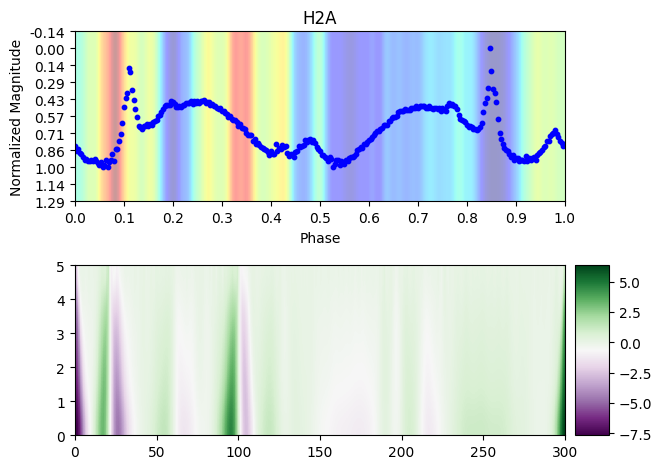

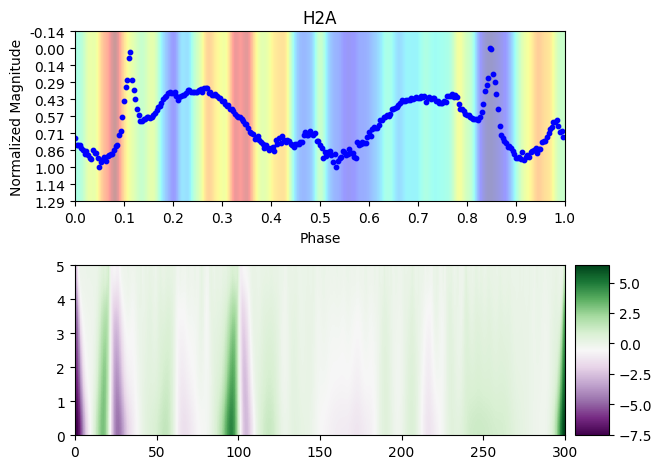

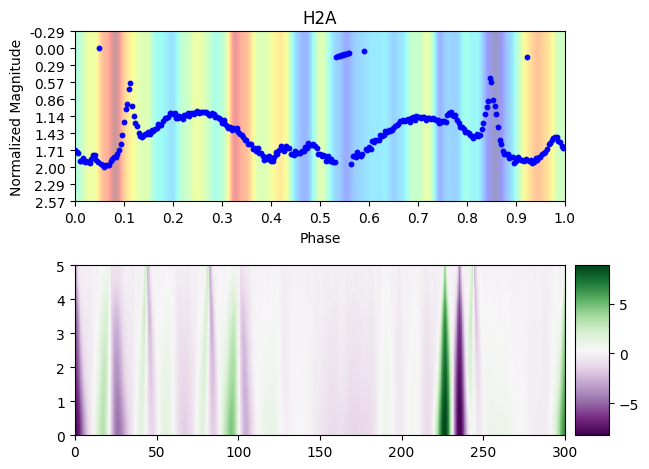

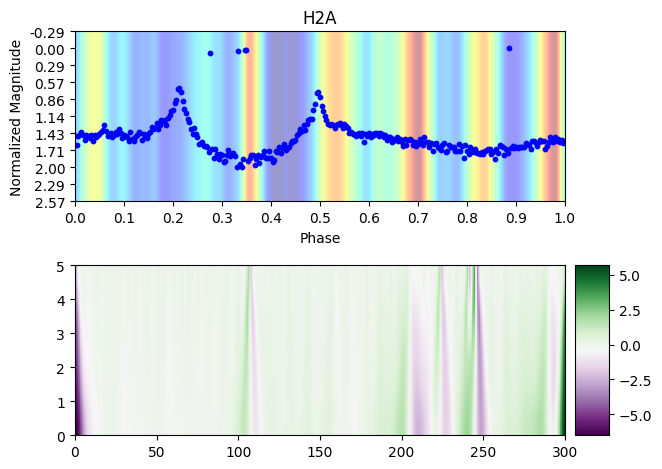

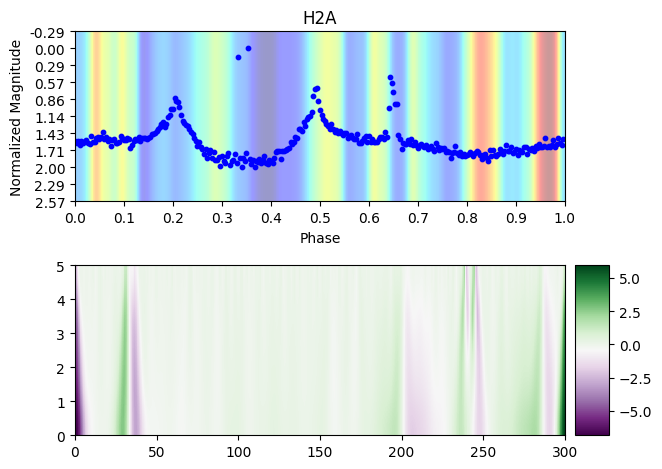

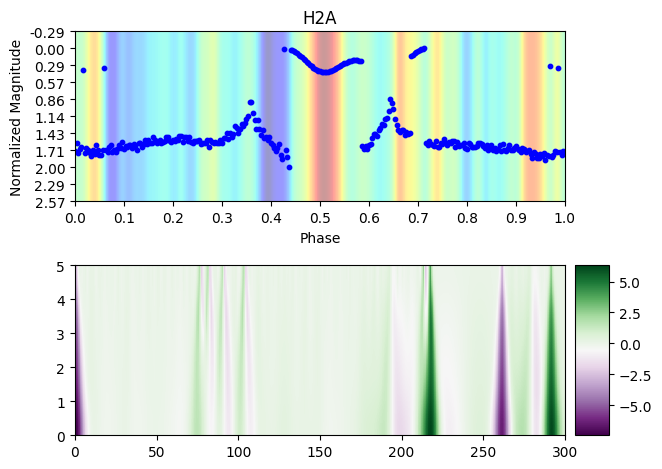

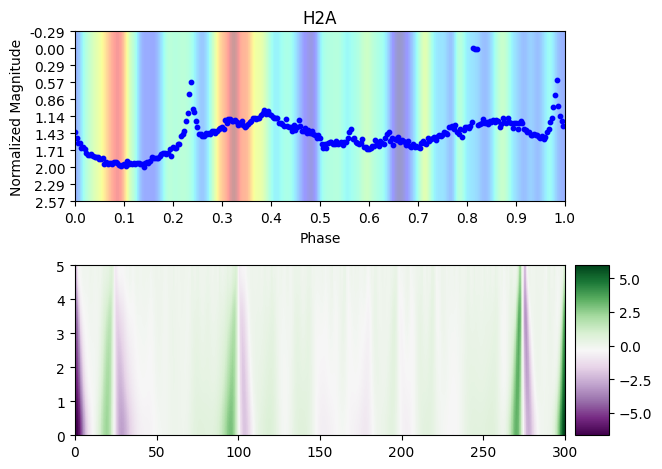

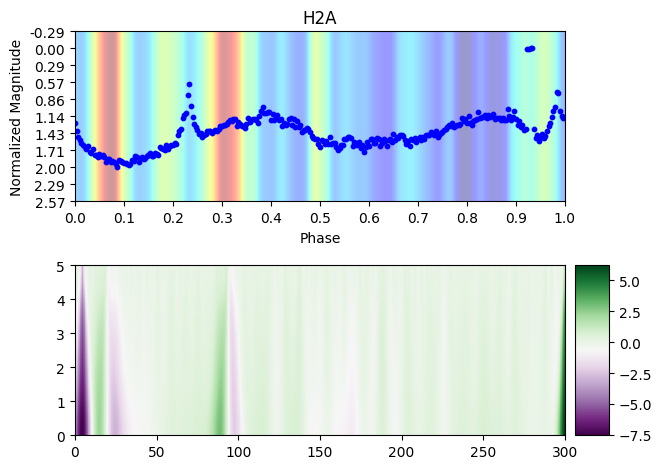

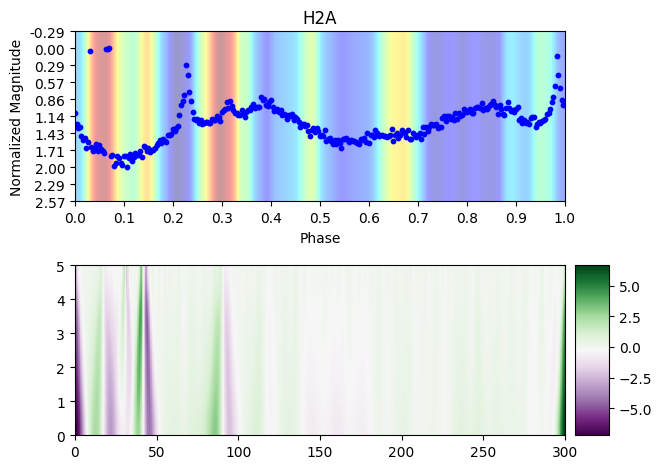

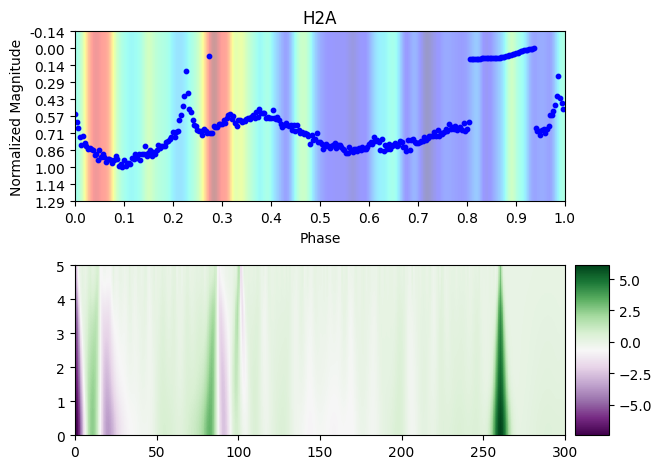

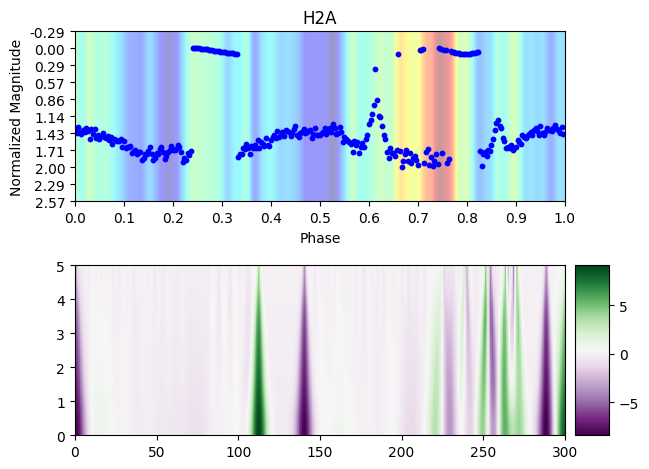

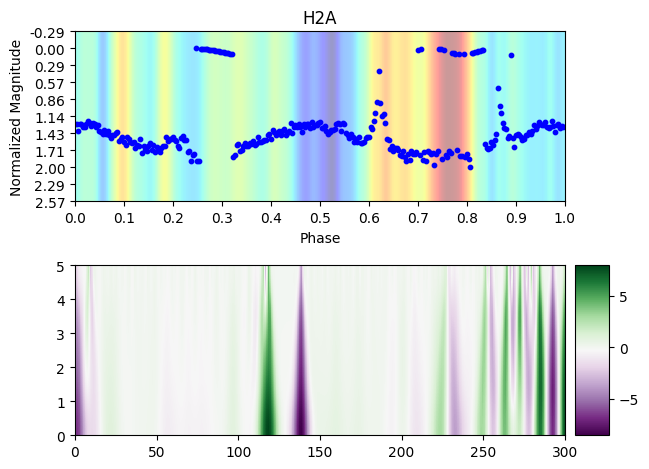

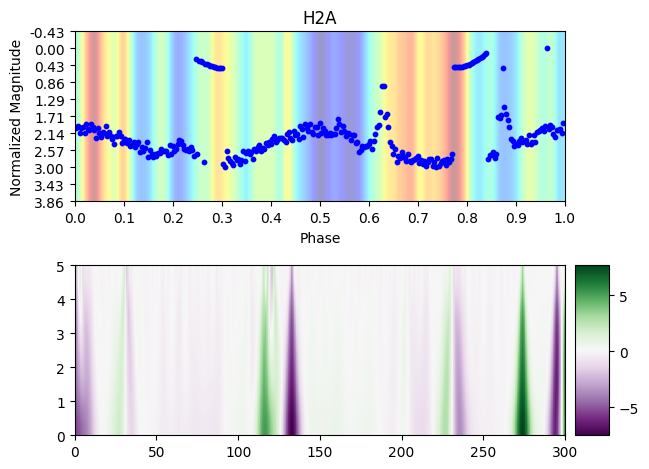

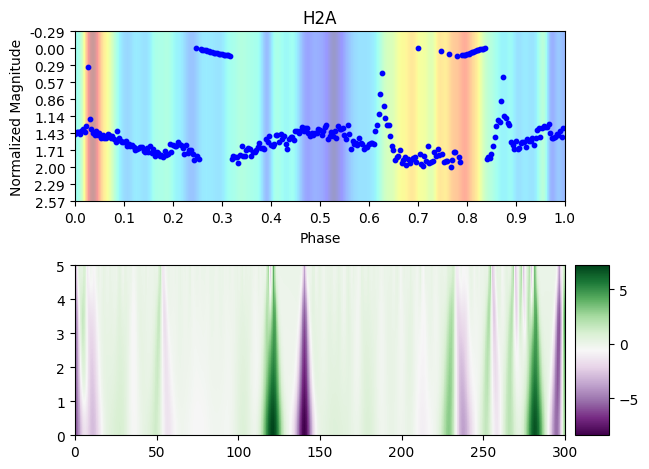

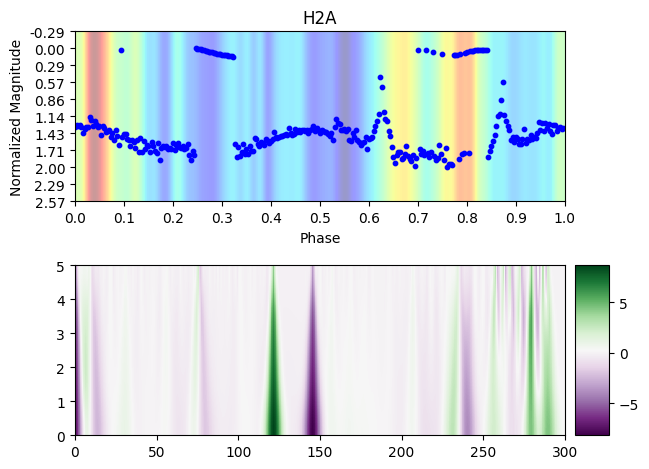

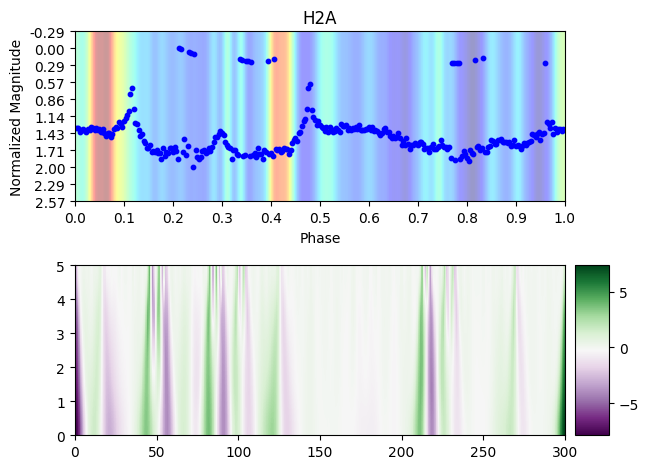

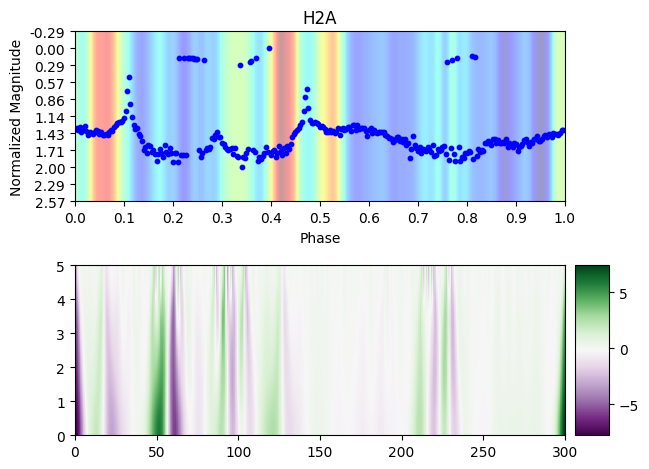

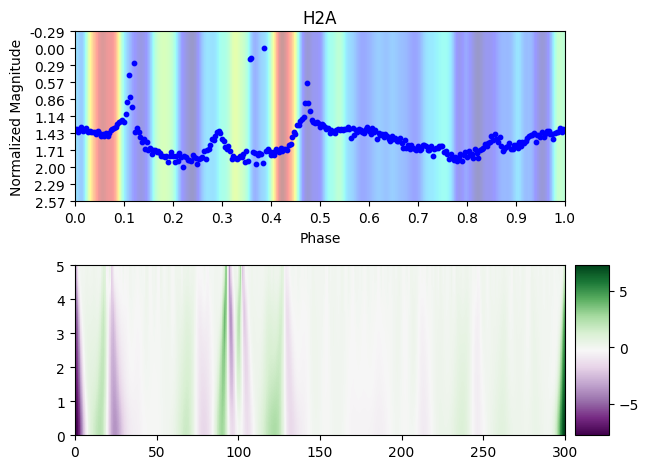

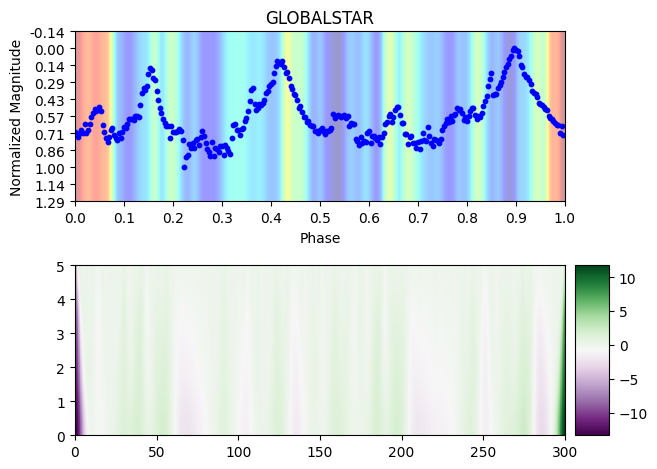

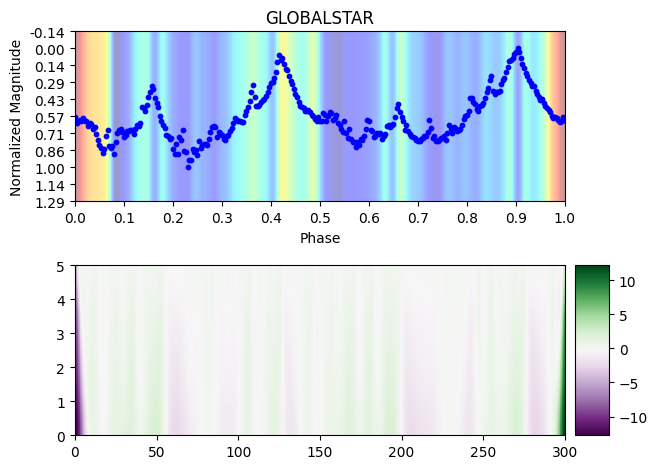

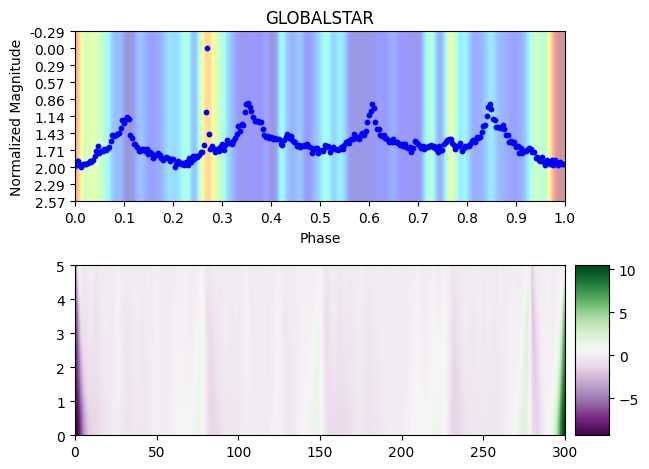

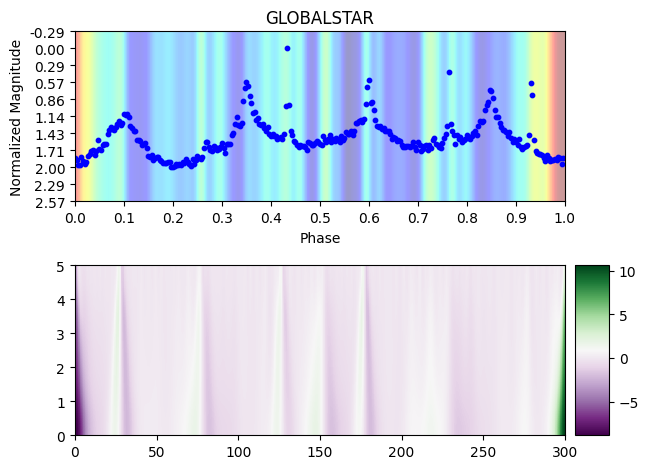

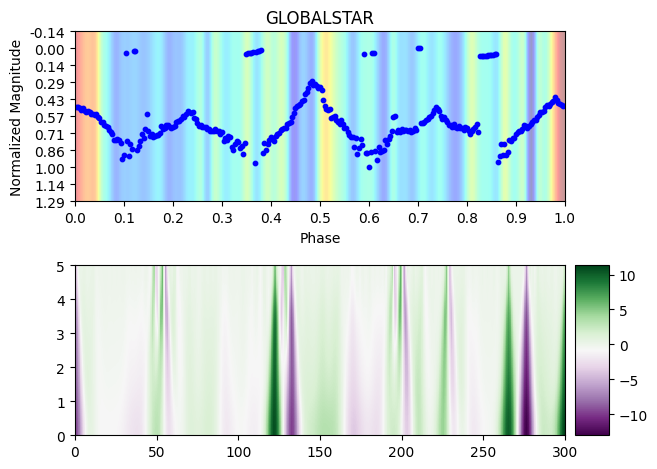

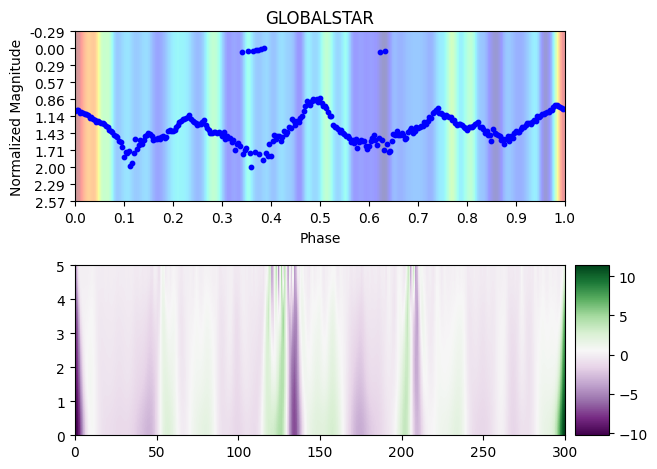

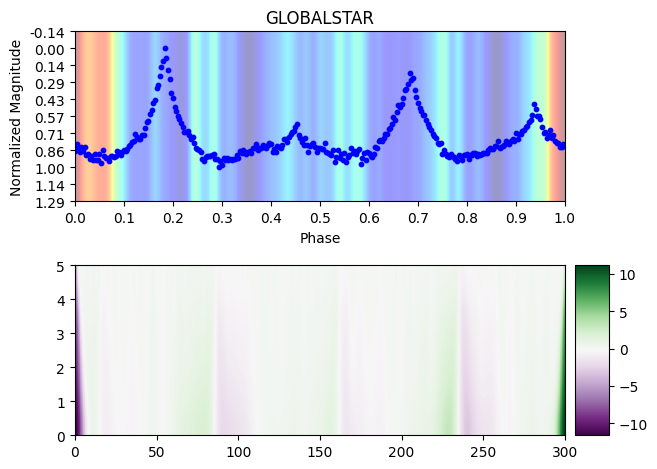

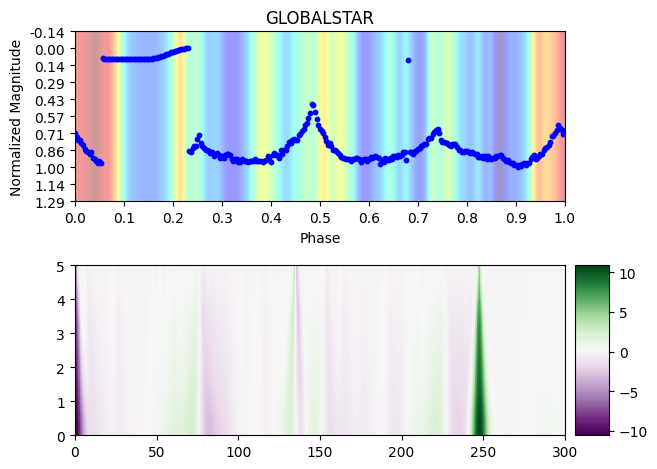

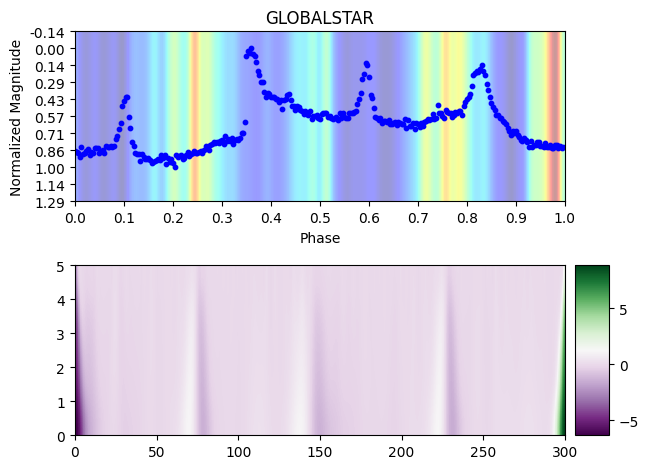

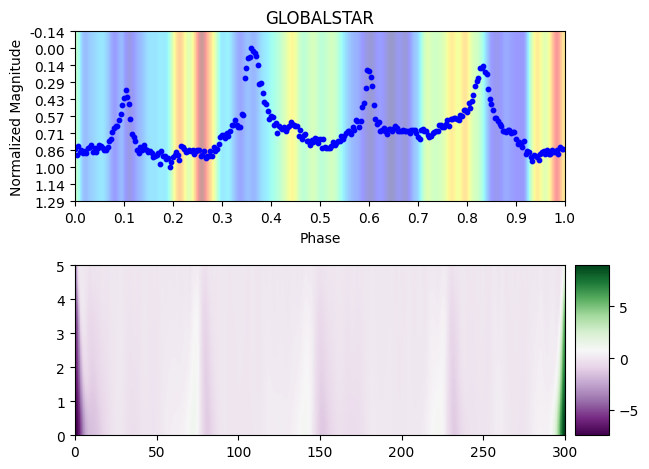

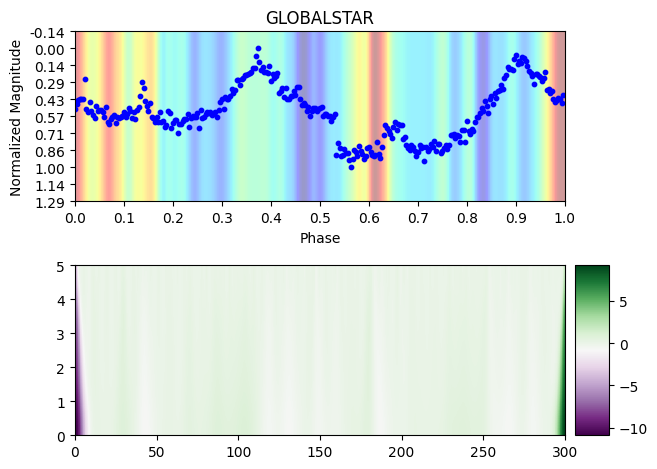

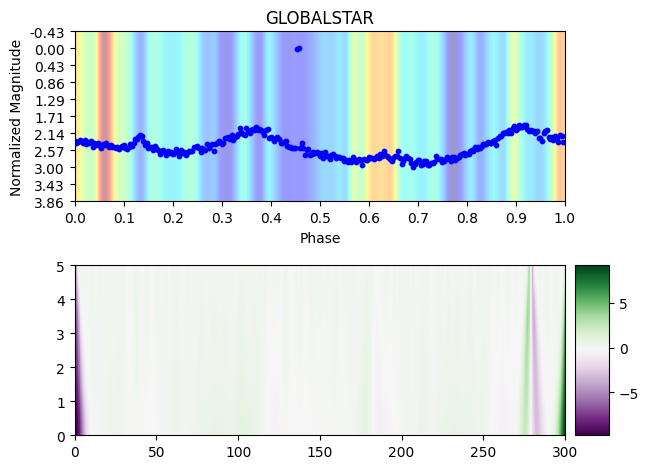

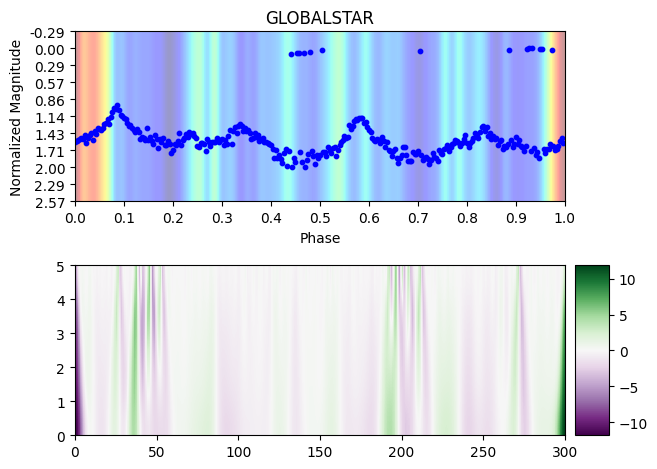

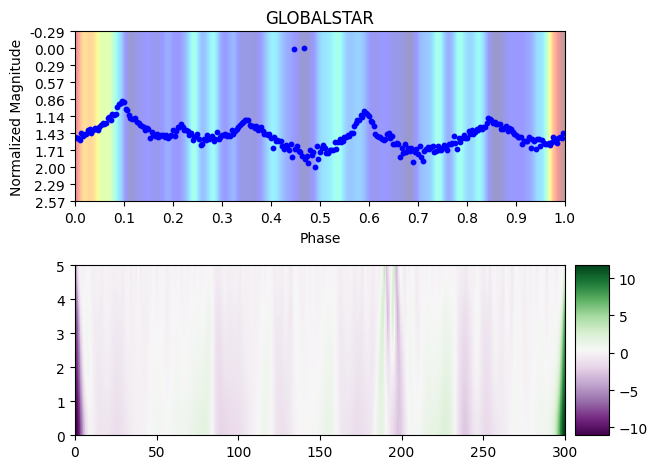

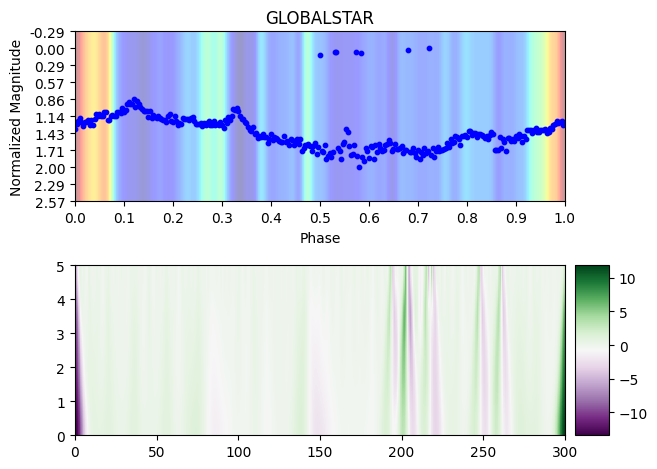

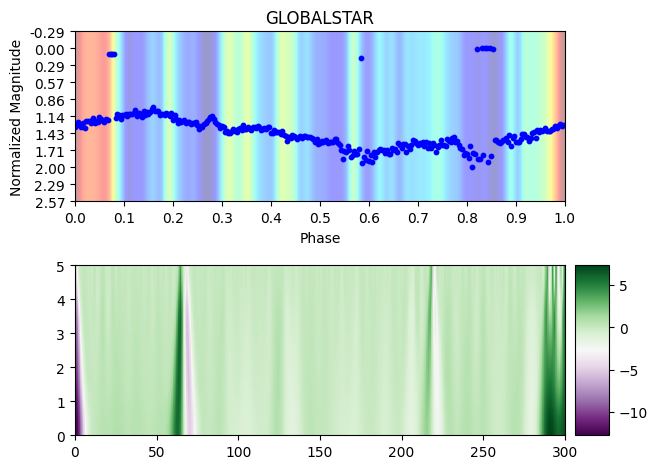

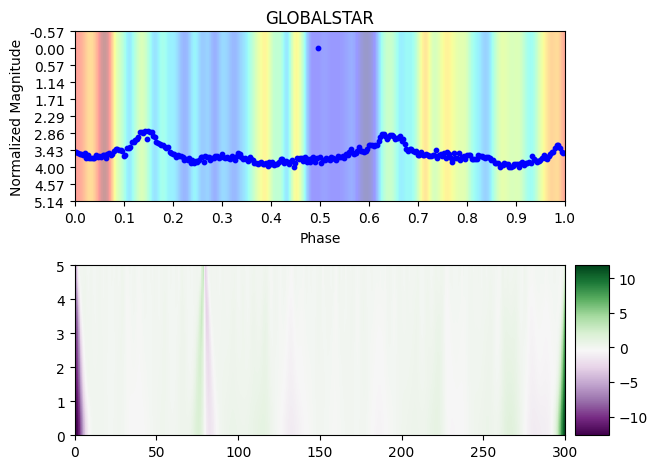

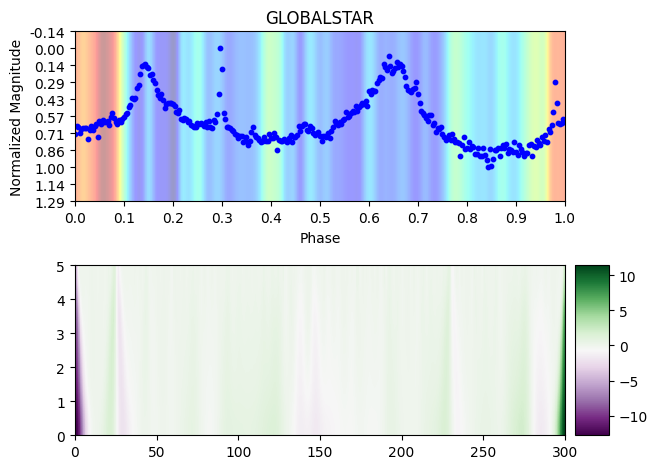

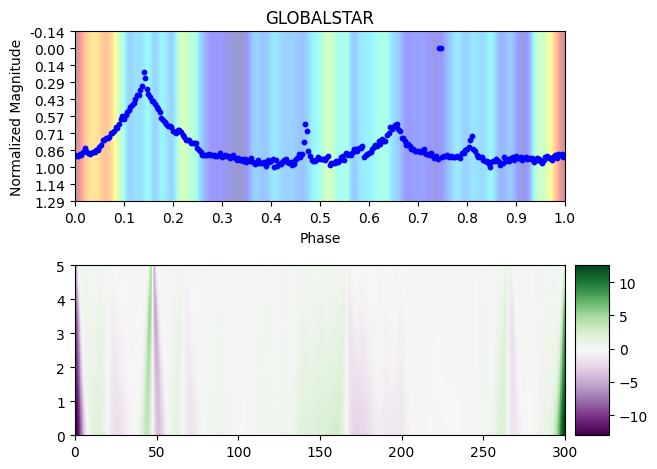

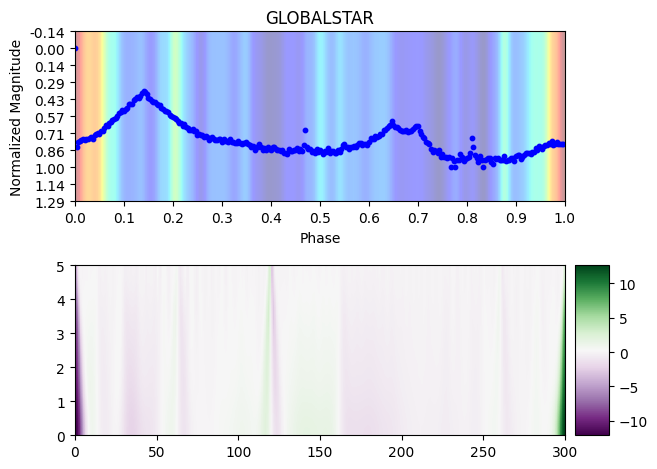

In [149]:
import torch.nn.functional as F
from scipy.ndimage import zoom
from collections import defaultdict

N = 20
SAVE = True
found = defaultdict(int)
found_data = defaultdict(list)

for (wavelet, lc) in zip(val_loader, val_loader2):
    l = lc['data']
    y_true = lc["target"]

    if found[int(y_true.item())] >= N:
        continue


    d = wavelet['data'].to("cuda").float()
    out = module.net.forward(d).detach().cpu().numpy()
    conv = module.net.get_embedding(d)
    xxx = F.avg_pool1d(conv, conv.size()[2])
    # conv = conv.view(conv.size(0), -1).detach().cpu().numpy()
    # xxx = module.net.linear(conv)
    target = np.argmax(out, axis=1).squeeze()
    w = module.net.linear.weight

    if target.item() != y_true.item():
        continue

    found[int(target.item())] += 1
    print("FOUND", target)

        
    # heatmap = conv.squeeze() @ w
    # print(module.net)
    
    weights = w[target, :].detach().cpu().numpy()
    conv = conv.squeeze().detach().cpu().numpy()

    heatmap = weights @ conv

    found_data[int(target.item())].append((heatmap, l, d.detach().cpu().numpy()))

    # plot(heatmap, l)
   
os.makedirs("./plots", exist_ok=True) 
        
def plot(heatmap, l,d=None, i=0, j=0, save=False):
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    heatmap = zoom(np.row_stack([heatmap]*10), zoom=(2,4))

    # fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(projection='3d')
    # ax = fig.add_subplot()
    size = 300
    # fig, ax = plt.subplots()
    # fig, ax = plt.subplots(figsize=(4,5)) 
    fig, (ax1, ax2) = plt.subplots(2, 1)
    l = l.squeeze()
    x = np.array(range(300))[l!=0]
    l = l[l!=0].squeeze() 
    max_l = l.max() 
    l = l / max_l * size * 0.7 + size * 0.1 
    max_y = size
    im = ax1.imshow(heatmap, extent=[0, 300, 0, max_y], cmap='jet', alpha=0.4, aspect='auto')
    ax1.scatter(x, l, color='blue', s=10)
    # ax1.plot(x, l, color='blue')
    ax1.set_ylim(max_y, 0)
    ax1.set_title(f"{data_cfg.class_names[i].upper()}")
    ax1.set_xlabel("Phase")
    ax1.set_ylabel("Normalized Magnitude")
    ax1.set_xticks(range(0,301,30), np.arange(0,301,30)/300)

    yticks = np.arange(0,size+1,size//10)
    ylabels = [f'{x:1.2f}' for x in (np.arange(0,size+1,size//10)-size*0.1)/(0.7*size/int(max_l))]
    ax1.set_yticks(yticks, ylabels)

    ax1_divider = make_axes_locatable(ax1)
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    # cb1 = fig.colorbar(im, cax=cax1)
    cax1.axis('off')
    plt.tight_layout()
    
    # divider = make_axes_locatable(ax)
    # ax2 = divider.append_axes("bottom", size=.8, pad=.3)
    # divider2 = make_axes_locatable(ax2)
    # cax = divider.append_axes("right", size=0.08, pad=0.1)
    d = d.reshape(-1,300)
    im2 = ax2.imshow(zoom(d, zoom=(100//5, 1)),cmap='PRGn',  extent=[0,300,0,100], aspect='auto')
    yticks2 = np.arange(0,101,100//5)
    ylabels2 = [f'{x}' for x in range(0,6)]
    ax2.set_yticks(yticks2, ylabels2)
    ax2_divider = make_axes_locatable(ax2)
    cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
    cb1 = fig.colorbar(im2, cax=cax2)

    # im2 = ax[1].imshow(zoom(d, zoom=(300//5, 1)),cmap='PRGn')
    # plt.colorbar(im2)



    # two plots in one figure
    # axs.imshow(heatmap, cmap='jet', alpha=0.3, extent=[0,300,0,100])
    
    if save:
        plt.savefig(f"./plots/{data_cfg.class_names[i]}_{j}.png")
    else:
        plt.show()

for k, v in found_data.items():
    for i, (heatmap, l, d) in enumerate(v):
        plot(heatmap, l,d, k, i, save=SAVE)

    # plt.imshow(zoom(heatmap, zoom=(10,10)),  cmap='jet', alpha=0.3)

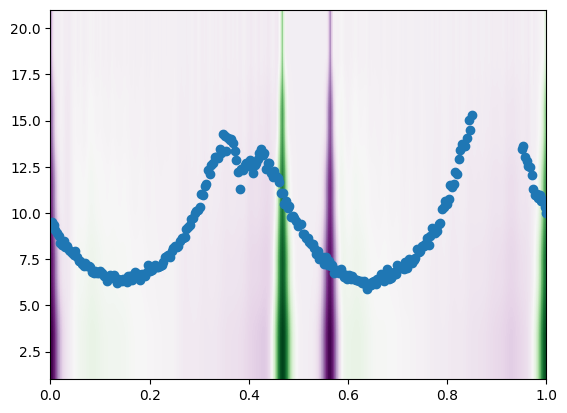

In [84]:
idx = 1100
y = val_set2[idx]["data"]
t = np.linspace(0,1,300)
plt.scatter(t[y!=0], y[y!=0]*10) 
wav = val_set[idx]["data"].reshape(-1,300)

# cwtmatr_yflip = np.flipud(cwtmatr)
plt.imshow(wav, extent=[0, 1, 1, N+1], cmap='PRGn', aspect='auto')
            

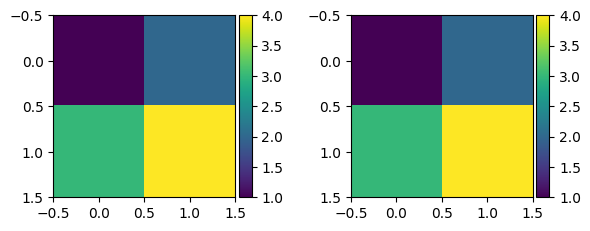

In [132]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.5)

im1 = ax1.imshow([[1, 2], [3, 4]])
ax1_divider = make_axes_locatable(ax1)
# Add an Axes to the right of the main Axes.
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)

im2 = ax2.imshow([[1, 2], [3, 4]])
ax2_divider = make_axes_locatable(ax2)
# Add an Axes above the main Axes.
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
# Change tick position to top (with the default tick position "bottom", ticks
# overlap the image).
# cax2.xaxis.set_ticks_position("top")

plt.show()

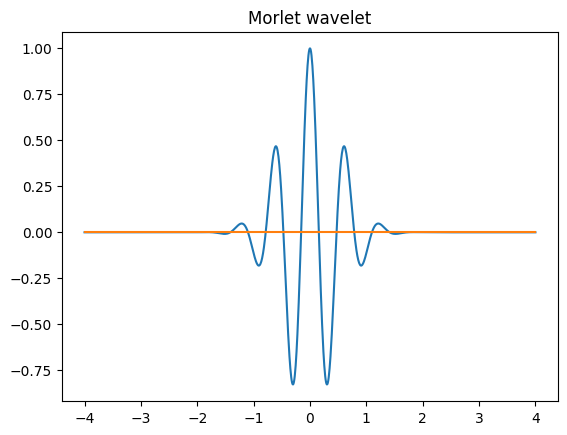

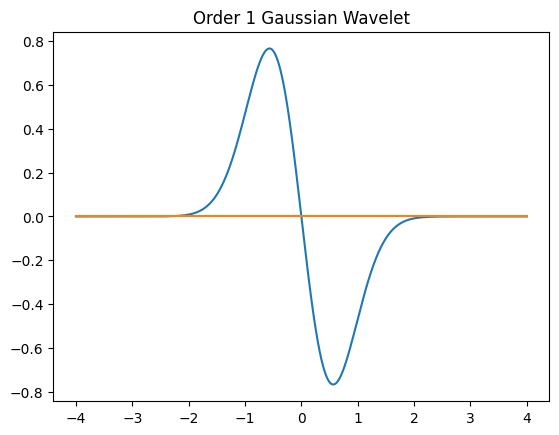

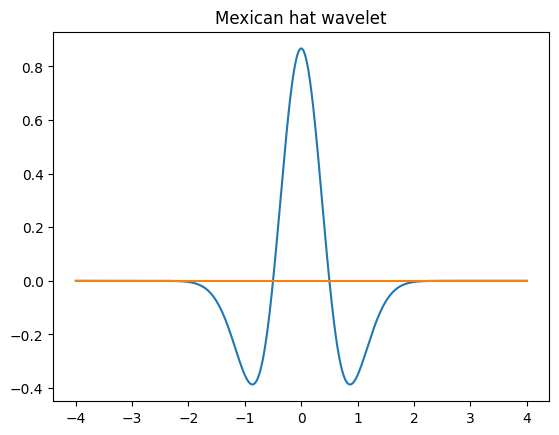

In [3]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
types = [
    ("morl", "Morlet wavelet"),
    ("gaus1", "Order 1 Gaussian Wavelet"),
    ("mexh", "Mexican hat wavelet")
]
for n, m in types:
    [x,y] = pywt.ContinuousWavelet(n).wavefun(level=10)
    t = np.linspace(-4,4, len(x))
    plt.plot(t,x)
    plt.plot(t,x/x - 1)
    plt.title(m)
    plt.savefig(f"{n}.png")
    plt.show()

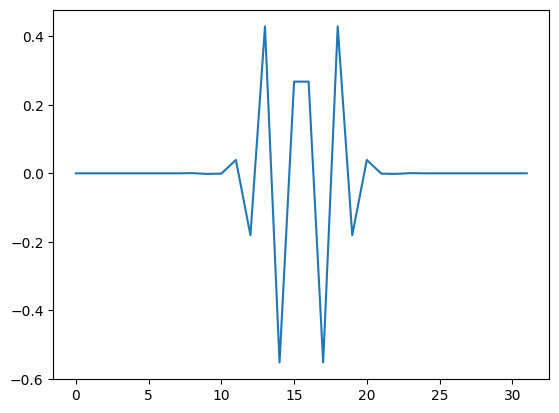

In [180]:
plt.plot(x)
# plt.plot(y)